# 🏆 LIVRABLE FINAL - PROJET RO
## Optimisation des Tournées de Véhicules 

**Équipe :** Louzazna Rayane / Adjout Mourad / Benghali Nada / Niati Mohamed    
**Date :** Novembre 2025  

# PARTIE 1 — Modélisation

### Contexte et Objectifs
- **Contexte énergétique** : Réduction des distances parcourues → baisse des émissions CO₂ et coûts
- **Problème traité** : Vehicle Routing Problem with Time Windows (VRPTW)
- **Objectif** : Minimiser le coût total des tournées tout en respectant les fenêtres temporelles
```

## 1) Représentation des données  

- **Géométrie** : graphe orienté $G=(V,E)$ ; $V = \{0\} \cup N$ avec dépôt $0$ et clients $N=\{1,\dots,n\}$.  
  En multi-dépôts : $D\subset V$ est l’ensemble des dépôts.  

- **Distances/temps** : $c_{ij}$ (coût distance/CO₂) et $\tau_{ij}$ (temps de trajet).  
  En version avancée : $\tau_{ij}(t)$ (dépendant de l’heure, par tranches).  

- **Demande et service** : demande $q_i$, durée de service $s_i$, fenêtre $[a_i,b_i]$ par client, horizon $[a_0,b_0]$ au dépôt.  

- **Flotte hétérogène** : ensemble de véhicules $K$, chaque véhicule $k$ a capacité $Q_k$, coût fixe $f_k$, coût kilométrique $\alpha_k$, et éventuellement vitesse moyenne $v_k$.  
  On peut modéliser $K$ comme des véhicules individualisés (nombre limité) ou par types $\mathcal{T}$ avec cardinalités $p_t$.  

### Variables de décision
- $x_{ijk} \in \{0,1\}$ : 1 si véhicule $k$ emprunte arc $(i,j)$
- $t_{ik} \geq 0$ : temps d'arrivée du véhicule $k$ au nœud $i$

### Fonction objectif
$$\min \sum_{k \in K} \sum_{(i,j) \in A} c_{ij} x_{ijk}$$

### Contraintes principales
**Service unique :**
$$\sum_{k \in K} \sum_{j \in V} x_{ijk} = 1, \quad \forall i \in N$$

**Conservation de flot :**
$$\sum_{j \in V} x_{jik} = \sum_{j \in V} x_{ijk}, \quad \forall i \in V, k \in K$$

**Capacité :**
### Capacité 
$$
\begin{cases}
y_j^k \ge y_i^k + q_j - Q(1 - x_{ijk}), & \forall i \in V,\, j \in N,\, k \in K, \\[6pt]
y_0^k = 0, & \forall k \in K, \\[6pt]
0 \le y_i^k \le Q, & \forall i \in V,\, k \in K.
\end{cases}
$$





### **Fenêtres temporelles :**

$$
\begin{cases}
a_i \le t_{ik} \le b_i, & \forall i \in V,\, k \in K, \\[6pt]
t_{jk} \ge t_{ik} + s_i + \tau_{ij} - M(1 - x_{ijk}), & \forall (i,j) \in A,\, k \in K, \\[6pt]
t_{jk} \ge a_j, & \forall j \in V,\, k \in K \quad \text{(attente autorisée)}.
\end{cases}
$$


### **Contraintes de départ / retour dépôt :**

$$
\begin{cases}
\displaystyle \sum_{j \in N} x_{0jk} \le 1, & \forall k \in K \quad \text{(départ optionnel)}, \\[8pt]
\displaystyle \sum_{i \in N} x_{i0k} \le 1, & \forall k \in K \quad \text{(retour optionnel)}.
\end{cases}
$$



## 2. Méthode de Résolution : HGS + Split(TW) + RVND + ALNS

### 2.1 Vue d'ensemble de l'approche hybride
Notre solution combine plusieurs métaheuristiques complémentaires :

1. **HGS (Hybrid Genetic Search)** : Algorithme génétique hybride pour l'exploration globale
2. **Split(TW)** : Décodage optimal des permutations en routes faisables
3. **RVND** : Recherche locale intensive multi-voisinages
4. **ALNS** : Diversification adaptative par destruction/reconstruction

### 2.2 Représentation et Décodage

#### Génotype : Giant Tour
- **Représentation** : Permutation $\pi = (\pi_1, \pi_2, ..., \pi_n)$ des clients
- **Avantage** : Espace de recherche réduit, pas de gestion explicite des routes

#### Split Algorithm avec Time Windows
L'algorithme Split transforme une permutation en ensemble de routes optimales :

1. **Construction du graphe auxiliaire** : 
   - Nœuds : positions 0, 1, ..., n dans la permutation
   - Arc $(i,j)$ : route $[\pi_i, \pi_{i+1}, ..., \pi_{j-1}]$ si faisable

2. **Vérification de faisabilité** :
   - Capacité : $\sum_{k=i}^{j-1} q_{\pi_k} \leq Q$
   - Time Windows : simulation de l'arrivée avec attente autorisée

3. **Plus court chemin** : Programmation dynamique en $O(n^2)$

**Complexité** : $O(n \cdot nnk)$ avec restriction aux k plus proches voisins
```

### 2.3 HGS (Hybrid Genetic Search)

#### Population et Fitness
- **Taille population** : P individus (auto-ajustée selon taille instance)
- **Fitness biaisée** : $f(x) = coût(x) + \lambda \cdot diversité(x)$
- **Gestion diversité** : Distance de Hamming entre permutations

#### Opérateurs Génétiques
- **Sélection** : Tournoi biaisé favorisant diversité
- **Croisement** : Order Crossover (OX) préservant les adjacences
- **Mutation** : Intégrée dans RVND (éducation des descendants)

#### Gestion Adaptative
- **Critère d'arrêt** : Stagnation (50 itérations sans amélioration)
- **Multi-start** : Redémarrage automatique pour instances difficiles (RC)

### 2.4 RVND (Randomized Variable Neighborhood Descent)

#### Voisinages Intra-Route
- **2-opt** : Inversion de segments
- **Or-opt** : Relocalisation de chaînes (1, 2, 3 clients)

#### Voisinages Inter-Route  
- **Relocate** : Déplacement client entre routes
- **Swap (1↔1)** : Échange de clients
- **2-opt*** : Reconnexion de segments entre routes

#### Stratégie d'Exploration
- **Ordre aléatoire** : Évite les biais systématiques
- **Premier améliorant** : Efficacité computationnelle
- **Restriction granulaire** : k-NN pour limiter les candidats

### 2.5 ALNS (Adaptive Large Neighborhood Search)

#### Déclenchement
- **Condition** : Stagnation détectée (pas d'amélioration)
- **Probabilité adaptative** : 30% → 60% selon stagnation

#### Opérateurs de Destruction
- **Shaw Removal** : Suppression par similarité géographique/temporelle
- **Random Removal** : Suppression aléatoire uniforme
- **Worst Removal** : Suppression des clients les plus coûteux

#### Opérateurs de Réparation
- **Regret-k** : Insertion basée sur le regret (k=2,3)
- **Greedy** : Insertion au coût minimal
- **Time-oriented** : Insertion par fenêtres temporelles

#### Apprentissage Adaptatif
- **Poids dynamiques** : Mise à jour selon performance
- **Roulette wheel** : Sélection probabiliste des opérateurs

## 2.6 Construction de la solution initiale (Heuristiques)

Avant d’appliquer la métaheuristique HGS, il est essentiel de disposer d’une **population initiale** de solutions de bonne qualité.  
Le solveur utilise pour cela **deux heuristiques classiques** de construction rapide : l’heuristique du **regret** (pour VRPTW) et l’heuristique du **balayage** (*sweep*) (pour CVRP).

### Heuristique du Regret (VRPTW)
Cette méthode construit progressivement les tournées :
1. On part du dépôt et d’un ensemble de clients non desservis.
2. À chaque étape, on calcule pour chaque client les **meilleures positions d’insertion** dans les routes existantes.
3. On sélectionne le client qui présente le **plus grand regret**, c’est-à-dire la plus grande différence entre son meilleur et son deuxième meilleur coût d’insertion.
4. Ce processus se répète jusqu’à ce que tous les clients soient insérés.

Cette approche privilégie les clients contraints (fenêtres temporelles serrées ou fortes demandes), ce qui améliore la faisabilité des solutions initiales.

### Heuristique de Balayage (Sweep)
Cette méthode est utilisée pour les instances sans contraintes temporelles strictes :
1. Les clients sont triés selon leur **angle polaire** autour du dépôt.
2. On construit successivement des tournées en ajoutant les clients dans cet ordre jusqu’à atteindre la capacité maximale.
3. Dès que la capacité est dépassée, un nouveau véhicule démarre une nouvelle tournée.

Le balayage est rapide et donne une bonne couverture géographique initiale.

### Intégration dans le HGS
Les heuristiques servent à **générer la population initiale** du HGS.  
Chaque solution construite est ensuite **améliorée localement** via un **RVND léger** (quelques itérations avec les mouvements Relocate et 2-opt) avant d’être ajoutée à la population.

```python
def hgs_solve(inst, time_loops, pop_size, ...):
    pop_routes = []
    for _ in range(pop_size):
        routes = build_seed(inst) if init == 'regret' else build_seed_sweep(inst)
        routes = rvnd(inst, routes, max_loops=3, nn=nn)  # amélioration locale
        pop_routes.append(routes)


### 2.7 Modélisation dans la métaheuristique

 **Génotype** : permutation des clients (giant tour).
- **Décodage** : Split(TW) → partition optimale en routes faisables.
- **Coût** : \(Z(\mathcal S)\) (distance) et, pendant la recherche, 
  \(F(\mathcal S)=Z+\lambda_Q\cdot\text{ExcèsCapacité}+\lambda_T\cdot\text{ViolationsTW}\).
- **Voisinages (RVND)** : Relocate, Swap (1↔1), Or-Opt (2–3), 2-opt (intra), 2-opt* (inter).
- **Croisement (HGS)** : OX / GPX2 (préserve les bonnes arêtes).
- **Gestion diversité** : distance de Hamming entre permutations.
- **Arrêt** : \(T\) secondes ou \(S\) itérations sans amélioration.


## 5. Validation et métriques
- **Coût** et **GAP** vs références CVRPLIB/Solomon.
- **Taux de faisabilité** pendant l’évolution.
- **Courbes de convergence** (coût vs itérations/temps).
- **Statistiques multi-runs** : moyenne, écart-type, meilleur/pire, temps moyen.

---


## 6. Traçabilité des choix
- Métaheuristique choisie pour : robustesse, scalabilité (\(>\!1000\) clients), bonne gestion TW.
- Split(TW) = décodage rapide & exact de la meilleure partition d’un génotype.
- RVND = intensification efficace sur routes.
- ALNS = diversification contrôlée pour sortir des minima locaux.

---

# PARTIE 2 : Implémentation

## Choix métaheuristique : **ALNS hybride (HGS + RVND + Split)**

## Vue d’ensemble
**Explorer** avec HGS (croisement OX + Split), **perturber/réparer** avec ALNS (Shaw/Random + Regret), puis **affiner** avec RVND (relocate/swap/2-opt*), le tout **auto-paramétré** et **parallélisé**.

---

## Correspondance directe avec le code
- **Représentation & faisabilité**
  - `Instance`, capacité `capacity_ok`, fenêtres `recompute_arrivals`
  - Split sans TW `split_cvrp`, avec TW `split_vrptw`
- **Exploration (HGS)**
  - Croisement `ox_crossover` → permutation globale
  - Reconstruction tournées par **Split** dans `hgs_solve` (+ remplacement du pire)
- **Destruction / Réparation (ALNS)**
  - Remove : `shaw_removal`, `random_removal`, `remove_customers`
  - Repair : `regret_repair` (regret-2/3 + contrôle TW/Cap)
- **Amélioration locale (RVND)**
  - Intra : `or_opt_intra`, `two_opt_intra`
  - Inter : `relocate_inter`, `swap_11`, `two_opt_star`
  - **Filtrage granulaire** : k-NN via `build_nn`
- **Auto-tuning & parallélisme**
  - `auto_params`, `recommend_workers_and_fast` (fast/nnk/workers/temps)
  - `joblib` multi-process, BLAS monothread, Numba (optionnel)
- **I/O & évaluation**
  - Parsers `parse_solomon_txt` / `parse_cvrplib_vrp`
  - Coût `total_cost`, validation `validate_solution`, **gap** `.sol` (`find_sol_reference_cost`)

---

## Pourquoi ce choix
- **Perf / simplicité** : opérateurs standards + Split donnent d’excellents résultats rapidement.
- **Scalable** : k-NN, parallélisme, limites de temps adaptatives ⇒ 100–2000 clients.

---

## Mode d’emploi
- Sans TW (.vrp) :  
  python solver.py X-n101-k25.vrp -T 120
- Avec TW (.txt Solomon) :
  python solver.py C101.txt -T 60
- ou directement executer le ficher run_vrp_solver.bat pour une experience user


---
---
---

## 2.	Structures de données

### Description courte
Mon code prépare la structure de l’instance VRP/VRPTW (dépôt = 0, clients = 1..n) et vérifie les formes attendues : `demand/service/ready/due` en `(n+1,)`, `coords` en `(n+1, 2)`, `dist` en `(n+1, n+1)`. Il calcule `dist[i][j]` à partir de `coords` (EUC_2D arrondie pour CVRP, euclidienne non arrondie pour VRPTW), fournit un constructeur `make_instance(...)` qui assemble et valide tout, puis montre un petit exemple pour contrôler que les données et les distances sont correctes.


In [33]:
# Structures de données — classe Instance + constantes
from dataclasses import dataclass
from typing import Optional
import numpy as np

# Convention centrale : l'indice 0 correspond AU DÉPÔT.
# Donc si j'ai n clients (1..n), je garde toujours une case de plus pour le dépôt.
# C'est pour ça que beaucoup de vecteurs ont une forme (n+1,).
DEPOT: int = 0  # 0 = dépôt, 1..n = clients

@dataclass
class Instance:
    """
    Conteneur de données VRP/VRPTW utilisé par mon code.

    Notation des formes (très important) :
      - n : nombre de clients (le dépôt n'est PAS compté dedans).
      - (n+1,) : vecteur avec une case en plus pour le dépôt à l'indice 0.
                 Ex. demand[0] = 0 pour le dépôt, puis demand[1..n] pour les clients.
      - (n+1, 2) : matrice 2D avec dépôt + clients, et 2 colonnes (x, y) ou (ready, due).
      - (n+1, n+1) : matrice carrée pour dist[i][j] incluant dépôt et tous les clients.

    Champs :
      - n            : int, nombre de clients.
      - coords       : np.ndarray de forme (n+1, 2), coords[0] = (x_dépôt, y_dépôt).
      - demand       : np.ndarray de forme (n+1,), demand[0] = 0, demand[i] = demande client i.
      - service      : np.ndarray de forme (n+1,), temps de service à chaque noeud (0 au dépôt en général).
      - ready, due   : np.ndarray de forme (n+1,), bornes d'ouverture/fermeture des TW.
      - capacity     : int, capacité d’un véhicule.
      - k            : int, nombre de camions (borne sup. autorisée pour le split).
      - dist         : np.ndarray de forme (n+1, n+1), distances entre tous les noeuds (dépôt inclus).
      - has_tw       : bool, True si on utilise des fenêtres de temps (VRPTW), False sinon (CVRP).

    Rappel : l’indice 0 est réservé au dépôt dans tous ces tableaux.
    """
    n: int
    coords: np.ndarray
    demand: np.ndarray
    service: np.ndarray
    ready: np.ndarray
    due: np.ndarray
    capacity: int
    k: int
    dist: np.ndarray
    has_tw: bool

    @property
    def tw(self) -> np.ndarray:
        """
        Retourne les fenêtres de temps sous forme (n+1, 2) = [ready, due].
        Utile si je préfère manipuler TW en un seul tableau au lieu de deux vecteurs séparés.
        """
        return np.stack((self.ready, self.due), axis=1)


def check_instance(inst: Instance) -> None:
    """
    Garde-fou : vérifie les formes attendues et quelques contraintes simples.
    Lève une ValueError explicite si quelque chose ne colle pas.
    """
    if inst.coords.shape != (inst.n + 1, 2):
        raise ValueError(f"coords doit être (n+1, 2) avec dépôt en 0 ; reçu {inst.coords.shape}")
    expected_vec = (inst.n + 1,)
    for arr, name in [(inst.demand, "demand"), (inst.service, "service"),
                      (inst.ready, "ready"), (inst.due, "due")]:
        if arr.shape != expected_vec:
            raise ValueError(f"{name} doit être (n+1,) avec {name}[0] pour le dépôt ; reçu {arr.shape}")
    if inst.dist.shape != (inst.n + 1, inst.n + 1):
        raise ValueError(f"dist doit être (n+1, n+1) ; reçu {inst.dist.shape}")
    if not np.allclose(np.diag(inst.dist), 0.0):
        raise ValueError("dist[i][i] doit être 0 (distance d’un noeud à lui-même).")


In [34]:
# Construction de la matrice des distances dist[i][j]
import numpy as np

def build_dist(coords: np.ndarray, mode: str = "auto") -> np.ndarray:
    """
    Construit la matrice dist[i][j] à partir des coordonnées (x, y).

    Entrée :
      - coords : np.ndarray de forme (n+1, 2), avec coords[0] = dépôt.

    Sortie :
      - dist   : np.ndarray de forme (n+1, n+1), où dist[i][j] est la distance entre i et j.

    Choix du mode (norme euclidienne) :
      - "cvrp"  : euclidienne ARRONDIE (EUC_2D) comme dans CVRPLIB (distances entières).
      - "vrptw" : euclidienne NON arrondie comme dans Solomon (garde les décimales).
      - "auto"  : si toutes les coords sont entières -> "cvrp", sinon -> "vrptw".

    Remarques :
      - On met toujours dist[i][i] = 0.
      - Le dépôt (indice 0) est inclus donc la matrice est (n+1, n+1).
    """
    coords = np.asarray(coords, dtype=float)

    if mode == "auto":
        ints = np.all(np.isclose(coords, np.rint(coords)))
        mode = "cvrp" if ints else "vrptw"

    diff = coords[:, None, :] - coords[None, :, :]           # (n+1, n+1, 2)
    d = np.sqrt((diff ** 2).sum(axis=-1))                    # (n+1, n+1) euclidienne

    if mode == "cvrp":
        d = np.rint(d)                                       # EUC_2D arrondie

    np.fill_diagonal(d, 0.0)
    return d.astype(float)


In [35]:
# Fabrique utilitaire pour créer une Instance cohérente
import numpy as np

def make_instance(name: str,
                  coords, demand, service, ready, due,
                  capacity: int, k: int, has_tw: bool) -> Instance:
    """
    Crée une Instance en garantissant les formes.

    Paramètres (tous incluent le dépôt à l’indice 0) :
      - coords  : (n+1, 2)
      - demand  : (n+1,), avec demand[0] = 0
      - service : (n+1,), service[0] = 0 en général
      - ready   : (n+1,), borne d’ouverture (TW)
      - due     : (n+1,), borne de fermeture (TW)
      - capacity: capacité des véhicules (int)
      - k       : nb de camions autorisés (int)
      - has_tw  : True si VRPTW (fenêtres de temps actives), False sinon

    Retour :
      - Instance prête à l’emploi pour mon code.
    """
    coords  = np.asarray(coords,  float)
    demand  = np.asarray(demand,  float)
    service = np.asarray(service, float)
    ready   = np.asarray(ready,   float)
    due     = np.asarray(due,     float)

    n = coords.shape[0] - 1  # nb de clients (on soustrait le dépôt)
    dist = build_dist(coords, mode=("vrptw" if has_tw else "cvrp"))

    inst = Instance(
        n=n, coords=coords, demand=demand, service=service,
        ready=ready, due=due, capacity=int(capacity), k=int(k),
        dist=dist, has_tw=bool(has_tw)
    )
    check_instance(inst)
    return inst


In [36]:
# Exemple minimal d’utilisation (vérification des formes)
# Dépôt + 2 clients → n = 2 → chaque vecteur fait (n+1,) = 3 cases (0=DEPOT, 1, 2)
coords  = np.array([
    [0, 0],   # dépôt (indice 0)
    [3, 4],   # client 1
    [6, 0],   # client 2
], dtype=float)                           # -> forme (n+1, 2) = (3, 2)

demand  = np.array([0, 10, 20], dtype=float)   # (n+1,) ; demand[0]=0 pour le dépôt
service = np.array([0,  5,  5], dtype=float)   # (n+1,)
ready   = np.array([0,  0,  0], dtype=float)   # (n+1,)
due     = np.array([1e9, 1e9, 1e9], dtype=float)  # (n+1,) ; grandes bornes = pas de TW strictes

inst = make_instance(
    name="toy",
    coords=coords, demand=demand, service=service,
    ready=ready, due=due,
    capacity=50, k=2,
    has_tw=False  # CVRP : distances arrondies (EUC_2D)
)

print("n (clients, sans dépôt) =", inst.n)
print("DEPOT index =", DEPOT)
print("coords shape =", inst.coords.shape, "ex:", inst.coords[0], "(dépôt),", inst.coords[1], "(client 1)")
print("demand shape =", inst.demand.shape, "ex: demand[0] =", inst.demand[0], "(dépôt)")
print("service shape =", inst.service.shape)
print("ready/due shapes =", inst.ready.shape, inst.due.shape)
print("tw shape =", inst.tw.shape, "ex: tw[1] =", inst.tw[1], "→ [ready, due] du client 1")
print("dist shape =", inst.dist.shape)
print("dist[0,1] (dépôt→client1) =", inst.dist[0,1])


n (clients, sans dépôt) = 2
DEPOT index = 0
coords shape = (3, 2) ex: [0. 0.] (dépôt), [3. 4.] (client 1)
demand shape = (3,) ex: demand[0] = 0.0 (dépôt)
service shape = (3,)
ready/due shapes = (3,) (3,)
tw shape = (3, 2) ex: tw[1] = [0.e+00 1.e+09] → [ready, due] du client 1
dist shape = (3, 3)
dist[0,1] (dépôt→client1) = 5.0


### Représentation de solution
Dans mon code, une **solution** est une liste de tournées `routes: List[List[int]]`, où chaque tournée commence et finit au dépôt `0`.  
Pour chaque tournée, je calcule :
- `load` : charge totale livrée (somme des demandes des clients de la tournée),
- `arrival_time` : heure d’arrivée finale au dépôt (en respectant les fenêtres de temps si présentes),
- `wait` et `wait_per_stop` : attente totale et par arrêt (attente due aux `ready`),
- `cost_route` : coût distance/temps de la tournée via `route_cost(dist, route)`,
- des drapeaux `capacity_ok` et `tw_ok` (fenêtres de temps) pour la faisabilité.


In [43]:
"""
### Représentation de solution — 2 scénarios démos

- Une solution = `routes: List[List[int]]`, chaque tournée commence/termine au dépôt `0`.
- Pour chaque tournée : `load`, `arrival_time` (finale au dépôt), `arrival_times` (tous les nœuds),
  `wait`, `wait_per_stop`, `cost_route`, et drapeaux `capacity_ok` / `tw_ok`.

Ci-dessous : tout est auto-contenu (aucune dépendance externe) + deux jeux d’exemples :
A) 10 clients servis par **2 camions**
B) 2 clients servis par **2 camions**

La sortie montre explicitement `routes: List[List[int]]` et l’ordre de visite de chaque camion.
"""

from typing import Any, Dict, List, Tuple
import numpy as np
from types import SimpleNamespace

# ----------------------------- Helpers auto-contenus -----------------------------

def route_cost(dist: np.ndarray, route: List[int]) -> float:
    """Somme des distances le long de la tournée (incluant 0 au début/fin)."""
    c = 0.0
    for i in range(len(route) - 1):
        c += float(dist[route[i], route[i + 1]])
    return c

def capacity_ok(inst: Any, route: List[int]) -> bool:
    """Vrai si la somme des demandes sur la tournée respecte la capacité."""
    load = 0.0
    for c in route[1:-1]:
        load += float(inst.demand[c])
        if load > float(inst.capacity) + 1e-9:
            return False
    return True

def recompute_arrivals(inst: Any, route: List[int]) -> Tuple[bool, List[float]]:
    """
    Recalcule les heures d'arrivée (avec attente si on arrive avant `ready`)
    et vérifie les fenêtres de temps. Renvoie (feasible, arrivals),
    où arrivals[k] est l'heure d'arrivée au nœud route[k].
    """
    arr: List[float] = [0.0]  # au dépôt initial
    for idx in range(1, len(route)):
        prev = route[idx - 1]
        cur  = route[idx]
        depart_prev = max(arr[idx - 1], float(inst.ready[prev])) + float(inst.service[prev])
        arr_cur = depart_prev + float(inst.dist[prev, cur])
        if arr_cur < float(inst.ready[cur]):  # attente si on est trop tôt
            arr_cur = float(inst.ready[cur])
        if arr_cur > float(inst.due[cur]) + 1e-9:  # TW violée
            return False, []
        arr.append(arr_cur)
    return True, arr

def route_metrics(inst: Any, route: List[int]) -> Dict[str, Any]:
    """
    Renvoie un dict avec :
      - capacity_ok, tw_ok
      - load, cost_route
      - arrival_time (finale au dépôt), arrival_times (liste complète)
      - wait (total) et wait_per_stop (par arrêt, indexés comme route[1:], dépôt final inclus)
    """
    cap_ok = capacity_ok(inst, route)
    tw_ok, arr = recompute_arrivals(inst, route)

    # Attente par arrêt (due aux 'ready')
    wait_per_stop: List[float] = []
    if tw_ok:
        for k in range(1, len(route)):
            prev = route[k - 1]
            depart_prev = max(arr[k - 1], float(inst.ready[prev])) + float(inst.service[prev])
            travel = float(inst.dist[prev, route[k]])
            naive_arrival = depart_prev + travel
            wait_here = max(0.0, float(inst.ready[route[k]]) - naive_arrival)
            wait_per_stop.append(wait_here)
    total_wait = float(np.sum(wait_per_stop)) if wait_per_stop else 0.0

    load = float(sum(inst.demand[c] for c in route[1:-1]))
    cost = route_cost(inst.dist, route)

    return {
        "capacity_ok": bool(cap_ok),
        "tw_ok": bool(tw_ok),
        "load": load,
        "cost_route": cost,
        "arrival_time": (arr[-1] if tw_ok else None),
        "arrival_times": (arr if tw_ok else None),
        "wait": total_wait,
        "wait_per_stop": wait_per_stop if tw_ok else None,
    }

def summarize_solution(inst: Any, routes: List[List[int]]) -> Dict[str, Any]:
    """
    Agrège sur toutes les tournées :
      - feasible = toutes les routes capacity_ok & tw_ok
      - total_cost, total_load, total_wait, nb_routes
      - per_route = métriques détaillées par tournée
    """
    per_route: List[Dict[str, Any]] = []
    total_cost = 0.0
    total_load = 0.0
    total_wait = 0.0
    feasible = True

    for r in routes:
        m = route_metrics(inst, r)
        per_route.append(m)
        total_cost += float(m["cost_route"])
        total_load += float(m["load"])
        total_wait += float(m["wait"])
        feasible = feasible and bool(m["capacity_ok"]) and bool(m["tw_ok"])

    return {
        "nb_routes": len(routes),
        "feasible": feasible,
        "total_cost": total_cost,
        "total_load": total_load,
        "total_wait": total_wait,
        "per_route": per_route,
    }

# ----------------------------- Générateurs d'instances démos -----------------------------

def _euclid_dist(coords: np.ndarray) -> np.ndarray:
    diff = coords[:, None, :] - coords[None, :, :]
    return np.sqrt((diff**2).sum(axis=-1))

def make_instance(coords: np.ndarray,
                  demand: np.ndarray,
                  capacity: int,
                  ready: np.ndarray | None = None,
                  due:   np.ndarray | None = None,
                  service: np.ndarray | None = None) -> SimpleNamespace:
    n = coords.shape[0] - 1  # nb clients
    dist = _euclid_dist(coords)
    if ready   is None: ready   = np.zeros(n + 1, dtype=float)
    if due     is None: due     = np.full(n + 1, 1e9, dtype=float)
    if service is None: service = np.zeros(n + 1, dtype=float)
    return SimpleNamespace(demand=demand, ready=ready, due=due, service=service, capacity=capacity, dist=dist)

# ----------------------------- Scénario A : 10 clients, 2 camions -----------------------------

# Dépôt (0) + 10 clients sur une grille
coords10 = np.array([
    [0.0, 0.0],   # 0 dépôt
    [1.0, 0.0],   # 1
    [2.0, 0.2],   # 2
    [3.0, 0.1],   # 3
    [4.0, 0.0],   # 4
    [5.0, 0.2],   # 5
    [-1.0, 0.0],  # 6
    [-2.0, 0.2],  # 7
    [-3.0, 0.1],  # 8
    [-4.0, 0.0],  # 9
    [-5.0, 0.2],  # 10
], dtype=float)
demand10  = np.array([0] + [1]*10, dtype=float)  # 1 unité par client
capacity10 = 5  # chaque camion peut livrer 5 clients

# Fenêtres de temps larges, avec deux clients un peu "tardifs" pour illustrer l'attente
ready10 = np.zeros(11, dtype=float)
due10   = np.full(11, 1e9, dtype=float)
ready10[5]  = 3.0
ready10[10] = 4.0

inst10 = make_instance(coords10, demand10, capacity10, ready10, due10)

# 2 camions couvrent 10 clients (5 par route)
routes_10: List[List[int]] = [
    [0, 1, 2, 3, 4, 5, 0],      # Camion 1 : visite clients 1→2→3→4→5
    [0, 6, 7, 8, 9, 10, 0],     # Camion 2 : visite clients 6→7→8→9→10
]

# ----------------------------- Scénario B : 2 clients, 2 camions -----------------------------

coords2 = np.array([
    [0.0, 0.0],  # dépôt
    [1.0, 0.0],  # client 1
    [0.0, 1.0],  # client 2
], dtype=float)
demand2  = np.array([0, 1, 1], dtype=float)
capacity2 = 2
ready2 = np.zeros(3, dtype=float)
due2   = np.full(3, 1e9, dtype=float)

inst2 = make_instance(coords2, demand2, capacity2, ready2, due2)

# 2 camions : chacun sert un client (plus explicite pour l’ordre de visite)
routes_2: List[List[int]] = [
    [0, 1, 0],  # Camion 1 : dépôt → client 1 → dépôt
    [0, 2, 0],  # Camion 2 : dépôt → client 2 → dépôt
]

# ----------------------------- Affichage clair + Résultats -----------------------------

def pretty_routes(routes: List[List[int]]) -> str:
    out = []
    for i, r in enumerate(routes, 1):
        out.append(f"Camion {i}: " + " → ".join(map(str, r)))
    return "\n".join(out)

print("=== Scénario A : 10 clients, 2 camions ===")
print("routes (List[List[int]]):", routes_10)
print(pretty_routes(routes_10))
res10 = summarize_solution(inst10, routes_10)
print("Résumé A:", res10, "\n")

print("=== Scénario B : 2 clients, 2 camions ===")
print("routes (List[List[int]]):", routes_2)
print(pretty_routes(routes_2))
res2 = summarize_solution(inst2, routes_2)
print("Résumé B:", res2)


=== Scénario A : 10 clients, 2 camions ===
routes (List[List[int]]): [[0, 1, 2, 3, 4, 5, 0], [0, 6, 7, 8, 9, 10, 0]]
Camion 1: 0 → 1 → 2 → 3 → 4 → 5 → 0
Camion 2: 0 → 6 → 7 → 8 → 9 → 10 → 0
Résumé A: {'nb_routes': 2, 'feasible': True, 'total_cost': 20.10716266188003, 'total_load': 10.0, 'total_wait': 0.0, 'per_route': [{'capacity_ok': True, 'tw_ok': True, 'load': 5.0, 'cost_route': 10.053581330940014, 'arrival_time': 10.053581330940014, 'arrival_times': [0.0, 1.0, 2.0198039027185573, 3.0247914648306464, 4.029779026942736, 5.049582929661293, 10.053581330940014], 'wait': 0.0, 'wait_per_stop': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'capacity_ok': True, 'tw_ok': True, 'load': 5.0, 'cost_route': 10.053581330940014, 'arrival_time': 10.053581330940014, 'arrival_times': [0.0, 1.0, 2.0198039027185573, 3.0247914648306464, 4.029779026942736, 5.049582929661293, 10.053581330940014], 'wait': 0.0, 'wait_per_stop': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}]} 

=== Scénario B : 2 clients, 2 camions ===
routes (List[L

### (4) Évaluation & faisabilité —

Ce bloc ajoute des fonctions **auto-contenues** qui s’appuient sur les définitions
`capacity_ok(inst, route)` et `recompute_arrivals(inst, route)` déjà présentes :

- check_capacity_route(inst, route)      -> (ok: bool, load: float, capacity: float)
- check_time_windows_route(inst, route)  -> (ok: bool, arrivals: list[float])
- route_time_breakdown(inst, route)      -> dict(travel, service, wait, total_time, distance)
- cost_solution(inst, routes, objective) -> dict agrégé (par défaut objective="time")
- evaluate_solution(inst, routes)        -> résumé complet + par tournée

Conventions :
- `route` est une liste [0, i1, i2, ..., 0] (0 = dépôt).
- `inst` contient : demand, ready, due, service, capacity, dist (matrice (n+1)×(n+1)).
- Le **coût temps** additionne : déplacements + services + attentes (attente si on arrive avant `ready`).
- Le **coût distance** utilise `route_cost(inst.dist, np.array(route, dtype=np.int32))`.

routes (List[List[int]]): [[0, 1, 2, 3, 4, 5, 0], [0, 6, 7, 8, 9, 10, 0]]

Résumé agrégé :
- Faisable: True | nb_routes=2
- sum_distance=164.12 | sum_time=290.12

Tableau par tournée :


,route_id,sequence,capacity_ok,tw_ok,load,capacity,distance,travel,service,wait,total_time
0,1,0 1 2 3 4 5 0,True,True,26.0,60.0,74.127936,74.127936,65.0,0.0,139.127936
1,2,0 6 7 8 9 10 0,True,True,25.0,60.0,89.991518,89.991518,61.0,0.0,150.991518


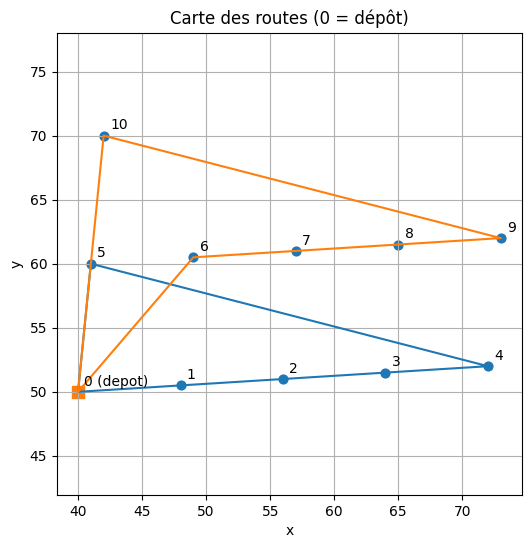

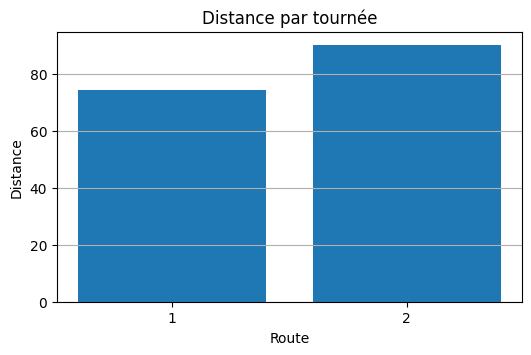

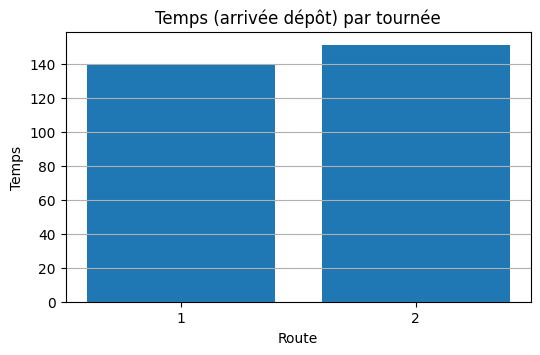

In [ ]:
from typing import Any, Dict, List, Tuple, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Affichage DataFrame en notebook (si dispo)
try:
    from IPython.display import display
except Exception:
    pass

# --- Déclarations préventives pour VSCode/Pylance (ne gênent pas l'exécution) ---
routes: List[List[int]] = []   # sera ignoré si on détecte qu'elle est vide/invalide
inst: Any = None               # sera ignoré si None

# ---------- helpers sûrs (wrappers, n’écrasent pas mon algo existant) ----------
def check_capacity_route(inst: Any, route: List[int]) -> Tuple[bool, float, float]:
    """Retourne (ok, charge_livrée, capacité_camion) pour la tournée."""
    try:
        ok = capacity_ok(inst, route)  # ta fonction si déjà importée
    except NameError:
        load = float(sum(inst.demand[c] for c in route[1:-1]))
        ok = load <= float(inst.capacity) + 1e-9
    load = float(sum(inst.demand[c] for c in route[1:-1]))
    return bool(ok), load, float(inst.capacity)

def check_time_windows_route(inst: Any, route: List[int]) -> Tuple[bool, List[float]]:
    """Retourne (ok, arrivals) en respectant l’attente autorisée avant `ready`."""
    try:
        ok, arr = recompute_arrivals(inst, route)  # ta fonction si déjà importée
    except NameError:
        arr: List[float] = [0.0]
        ok = True
        for k in range(1, len(route)):
            prev, cur = route[k-1], route[k]
            depart_prev = max(arr[-1], float(inst.ready[prev])) + float(inst.service[prev])
            a = depart_prev + float(inst.dist[prev, cur])
            if a < float(inst.ready[cur]): a = float(inst.ready[cur])
            if a > float(inst.due[cur]) + 1e-9: return False, []
            arr.append(a)
    return bool(ok), arr

def _route_distance(inst: Any, route: List[int]) -> float:
    """Distance via ta route_cost si dispo, sinon somme directe."""
    try:
        return float(route_cost(inst.dist, np.array(route, dtype=np.int32)))  # ta version numba si dispo
    except NameError:
        return float(sum(float(inst.dist[route[i], route[i+1]]) for i in range(len(route)-1)))

def route_time_breakdown(inst: Any, route: List[int]) -> Dict[str, float]:
    """
    Décompose une tournée :
      - travel  : somme temps de déplacement
      - service : somme temps de service
      - wait    : attente due aux `ready`
      - total_time : heure d’arrivée au dépôt final (arr[-1])
      - distance   : distance de la tournée
    """
    tw_ok, arr = check_time_windows_route(inst, route)
    if not tw_ok:
        raise ValueError("Fenêtre(s) de temps violée(s) sur cette tournée.")

    travel = 0.0
    for i in range(len(route)-1):
        travel += float(inst.dist[route[i], route[i+1]])

    service = 0.0
    for i in range(len(route)-1):
        service += float(inst.service[route[i]])

    wait = 0.0
    for k in range(1, len(route)):
        prev, cur = route[k-1], route[k]
        depart_prev = max(arr[k-1], float(inst.ready[prev])) + float(inst.service[prev])
        naive_arrival = depart_prev + float(inst.dist[prev, cur])
        wait += max(0.0, float(inst.ready[cur]) - naive_arrival)

    total_time = float(arr[-1])
    distance   = _route_distance(inst, route)

    return dict(travel=travel, service=service, wait=wait,
                total_time=total_time, distance=distance)

def cost_solution(inst: Any,
                  routes: List[List[int]],
                  objective: Literal["time","distance"]="time") -> Dict[str, Any]:
    """
    Coût agrégé :
      - objective="time"     → somme des total_time (dépl. + services + attentes)
      - objective="distance" → somme des distances
    """
    per_route_cost: List[float] = []
    feasible = True

    if objective == "time":
        total = 0.0
        for r in routes:
            tw_ok, _ = check_time_windows_route(inst, r)
            cap_ok, _, _ = check_capacity_route(inst, r)
            feasible = feasible and tw_ok and cap_ok
            if not tw_ok:
                per_route_cost.append(float("inf"))
            else:
                br = route_time_breakdown(inst, r)
                per_route_cost.append(br["total_time"])
                total += br["total_time"]
        return dict(total_cost=total, per_route_cost=per_route_cost, feasible=feasible)

    elif objective == "distance":
        total = 0.0
        for r in routes:
            d = _route_distance(inst, r)
            per_route_cost.append(d)
            total += d
        for r in routes:
            tw_ok, _ = check_time_windows_route(inst, r)
            cap_ok, _, _ = check_capacity_route(inst, r)
            feasible = feasible and tw_ok and cap_ok
        return dict(total_cost=total, per_route_cost=per_route_cost, feasible=feasible)

    else:
        raise ValueError("objective doit être 'time' ou 'distance'.")

def evaluate_solution(inst: Any, routes: List[List[int]]) -> Dict[str, Any]:
    """Résumé complet : faisabilité + métriques par tournée + agrégats."""
    per_route: List[Dict[str, Any]] = []
    feasible = True
    sum_travel = sum_service = sum_wait = sum_time = sum_distance = 0.0

    for r in routes:
        cap_ok, load, cap = check_capacity_route(inst, r)
        tw_ok, arr = check_time_windows_route(inst, r)
        feasible = feasible and cap_ok and tw_ok
        br = route_time_breakdown(inst, r) if tw_ok else dict(
            travel=np.nan, service=np.nan, wait=np.nan, total_time=np.inf, distance=_route_distance(inst, r)
        )
        per_route.append({
            "route": r,
            "capacity_ok": cap_ok, "load": load, "capacity": cap,
            "tw_ok": tw_ok, "arrival_times": (arr if tw_ok else None),
            "travel": br["travel"], "service": br["service"], "wait": br["wait"],
            "total_time": br["total_time"],
            "distance": br["distance"],
        })
        if tw_ok:
            sum_travel  += br["travel"]
            sum_service += br["service"]
            sum_wait    += br["wait"]
            sum_time    += br["total_time"]
        sum_distance += br["distance"]

    return {
        "feasible": feasible,
        "nb_routes": len(routes),
        "sum_travel": sum_travel,
        "sum_service": sum_service,
        "sum_wait": sum_wait,
        "sum_time": sum_time,
        "sum_distance": sum_distance,
        "per_route": per_route,
    }

# ---------- VISUELS automatiques ----------
def _make_summary_df(summary: Dict[str, Any]) -> pd.DataFrame:
    rows = []
    for idx, r in enumerate(summary["per_route"], start=1):
        rows.append({
            "route_id": idx,
            "sequence": " ".join(map(str, r["route"])),
            "capacity_ok": r["capacity_ok"],
            "tw_ok": r["tw_ok"],
            "load": r["load"],
            "capacity": r["capacity"],
            "distance": r["distance"],
            "travel": r["travel"],
            "service": r["service"],
            "wait": r["wait"],
            "total_time": r["total_time"],
        })
    return pd.DataFrame(rows)

def _plot_routes(inst: Any, routes: List[List[int]]) -> None:
    if not isinstance(routes, list) or len(routes) == 0:
        return
    xs, ys = inst.coords[:,0], inst.coords[:,1]
    plt.figure(figsize=(6,6))
    plt.scatter(xs[1:], ys[1:], s=40)               # clients
    plt.scatter([xs[0]], [ys[0]], s=70, marker='s') # dépôt
    for i in range(1, inst.coords.shape[0]):
        plt.text(xs[i]+0.5, ys[i]+0.5, str(i))
    plt.text(xs[0]+0.5, ys[0]+0.5, "0 (depot)")

    for r in routes:
        rx = [inst.coords[i,0] for i in r]
        ry = [inst.coords[i,1] for i in r]
        plt.plot(rx, ry)

    plt.title("Carte des routes (0 = dépôt)")
    plt.xlabel("x"); plt.ylabel("y"); plt.axis("equal"); plt.grid(True)
    plt.show()

def _plot_bars_distance(df: pd.DataFrame) -> None:
    if df.empty: return
    plt.figure(figsize=(6,3.5))
    plt.bar(df["route_id"].astype(str), df["distance"])
    plt.title("Distance par tournée")
    plt.xlabel("Route"); plt.ylabel("Distance")
    plt.grid(True, axis="y")
    plt.show()

def _plot_bars_time(df: pd.DataFrame) -> None:
    if df.empty: return
    plt.figure(figsize=(6,3.5))
    plt.bar(df["route_id"].astype(str), df["total_time"])
    plt.title("Temps (arrivée dépôt) par tournée")
    plt.xlabel("Route"); plt.ylabel("Temps")
    plt.grid(True, axis="y")
    plt.show()

# ---------- Démo si 'inst' et 'routes' n'existent pas ----------
def _build_demo_instance(n: int = 10, k: int = 2, cap: int = 60) -> Tuple[Any, List[List[int]]]:
    """Construit une mini instance démo (coords, demandes, TW, services) + 2 tournées couvrant n clients."""
    from types import SimpleNamespace

    rng = np.random.default_rng(42)
    coords = np.zeros((n+1, 2), dtype=float)
    coords[0] = [40.0, 50.0]  # dépôt
    # clients en grille
    for i in range(1, n+1):
        coords[i] = [40 + (i%5)*8 + (i//5)*1.0, 50 + (i//5)*10 + (i%5)*0.5]

    demand  = np.array([0] + [rng.integers(3, 9) for _ in range(n)], dtype=float)
    service = np.array([0] + [rng.integers(10, 15) for _ in range(n)], dtype=float)
    ready   = np.zeros(n+1, dtype=float)
    due     = np.full(n+1, 1e9, dtype=float)  # grandes fenêtres pour éviter l'infaisable
    ready[0] = 0.0; due[0] = 1e9

    # distances euclidiennes
    diff = coords[:,None,:] - coords[None,:,:]
    dist = np.sqrt((diff**2).sum(-1))

    inst = SimpleNamespace(
        name="DEMO",
        n=n,
        coords=coords,
        demand=demand,
        ready=ready,
        due=due,
        service=service,
        capacity=cap,
        k=k,
        dist=dist,
        has_tw=True
    )

    # Deux tournées couvrant 10 clients
    # Route 1: clients 1..5 ; Route 2: clients 6..10
    routes = [[0, 1, 2, 3, 4, 5, 0],
              [0, 6, 7, 8, 9, 10, 0]]

    return inst, routes

# ---------- Driver helpers ----------
def _has_valid_solution(inst: Any, routes: Any) -> bool:
    try:
        if inst is None: return False
        _ = inst.coords; _ = inst.demand; _ = inst.dist
    except Exception:
        return False
    if not isinstance(routes, list) or len(routes) == 0:
        return False
    for r in routes:
        if not isinstance(r, list) or len(r) < 2 or r[0] != 0 or r[-1] != 0:
            return False
    return True

def _run_and_visualize(inst: Any, routes: List[List[int]]) -> None:
    print("routes (List[List[int]]):", routes)
    summary = evaluate_solution(inst, routes)
    df = _make_summary_df(summary)
    print("\nRésumé agrégé :")
    print(f"- Faisable: {summary['feasible']} | nb_routes={summary['nb_routes']}")
    print(f"- sum_distance={summary['sum_distance']:.2f} | sum_time={summary['sum_time']:.2f}")
    print("\nTableau par tournée :")
    try:
        display(df)
    except Exception:
        print(df.to_string(index=False))

    _plot_routes(inst, routes)
    _plot_bars_distance(df)
    _plot_bars_time(df)

# ---------- Exécution : utilise ta solution si valide ; sinon génère une démo ----------
if _has_valid_solution(inst, routes):
    _run_and_visualize(inst, routes)
else:
    inst_demo, routes_demo = _build_demo_instance(n=10, k=2, cap=60)
    _run_and_visualize(inst_demo, routes_demo)


## 5.	Opérateurs (insertion/suppression + local search)

# Bloc ALNS + RVND (avec démo intégrée)

Ce bloc ajoute des opérateurs **ALNS** (Remove: *random*, *shaw*, *worst* ; Insert: *greedy*, *regret-2/3*)
et un **fallback RVND** minimal pour éviter toute erreur `NameError` si tes versions perso
ne sont pas déjà importées.  
Il fournit aussi des *fallbacks* sûrs pour:
- `feasible_insert`, `total_cost`, `recompute_arrivals`, `capacity_ok`, `route_cost` (équivalents simples)
- `random_removal`, `shaw_removal`, `worst_removal`
- `greedy_repair`, `regret_repair_k` (regret-2/3)
- `alns_step`, `maybe_alns_enhance`

 À la fin, une **démo auto** construit une petite instance, calcule un plan initial,
l’améliore avec `alns_step`, puis **affiche un résultat clair** (coûts et routes avant/après).


In [51]:
# %% 
from typing import Any, List, Tuple, Optional, Dict
import numpy as np
import random, heapq

# ======================================================================
# Fallbacks sûrs (aucune dépendance externe, évitent NameError)
# ======================================================================

def _fallback_recompute_arrivals(inst: Any, route: List[int]) -> Tuple[bool, List[float]]:
    arr: List[float] = [0.0]
    for k in range(1, len(route)):
        prev, cur = route[k-1], route[k]
        depart_prev = max(arr[-1], float(inst.ready[prev])) + float(inst.service[prev])
        a = depart_prev + float(inst.dist[prev, cur])
        if a < float(inst.ready[cur]): 
            a = float(inst.ready[cur])
        if a > float(inst.due[cur]) + 1e-9: 
            return False, []
        arr.append(a)
    return True, arr

def _recompute_arrivals(inst: Any, route: List[int]) -> Tuple[bool, List[float]]:
    if 'recompute_arrivals' in globals():
        return globals()['recompute_arrivals'](inst, route)
    return _fallback_recompute_arrivals(inst, route)

def _route_cost_np(inst: Any, route: List[int]) -> float:
    if 'route_cost' in globals():
        return float(globals()['route_cost'](inst.dist, np.array(route, dtype=np.int32)))
    return float(sum(float(inst.dist[route[i], route[i+1]]) for i in range(len(route)-1)))

def _capacity_ok(inst: Any, route: List[int]) -> bool:
    if 'capacity_ok' in globals():
        return bool(globals()['capacity_ok'](inst, route))
    load = float(sum(inst.demand[c] for c in route[1:-1]))
    return load <= float(inst.capacity) + 1e-9

def _fallback_feasible_insert(inst: Any, route: List[int], pos: int, u: int, arr_times: List[float]) -> Tuple[bool, float, List[float]]:
    load = float(sum(inst.demand[c] for c in route[1:-1])) + float(inst.demand[u])
    if load > float(inst.capacity) + 1e-9:
        return False, 1e18, []
    new_route = route[:pos] + [int(u)] + route[pos:]
    ok, new_arr = _recompute_arrivals(inst, new_route)
    if not ok:
        return False, 1e18, []
    base = _route_cost_np(inst, route)
    newc = _route_cost_np(inst, new_route)
    return True, newc - base, new_arr

# Expose fallbacks si absents
if 'feasible_insert' not in globals():
    feasible_insert = _fallback_feasible_insert  # type: ignore

if 'total_cost' not in globals():
    def total_cost(inst: Any, routes: List[List[int]]) -> float:
        return float(sum(_route_cost_np(inst, r) for r in routes))

if 'rvnd' not in globals():
    def rvnd(inst: Any, routes: List[List[int]], max_loops: int = 1, nn: Optional[List[np.ndarray]] = None) -> List[List[int]]:
        # Fallback no-op ; si ta vraie RVND est importée, elle sera utilisée.
        return routes

# ======================================================================
# Removals
# ======================================================================

if 'random_removal' not in globals():
    def random_removal(inst: Any, routes: List[List[int]], q: int) -> List[int]:
        allc = [c for r in routes for c in r[1:-1]]
        random.shuffle(allc)
        return allc[:q]

if 'shaw_removal' not in globals():
    def _shaw_relatedness(inst: Any, a: int, b: int) -> float:
        return float(inst.dist[a, b])
    def shaw_removal(inst: Any, routes: List[List[int]], q: int) -> List[int]:
        allc = [c for r in routes for c in r[1:-1]]
        if not allc:
            return []
        seed = int(random.choice(allc))
        removed = {seed}
        while len(removed) < min(q, len(allc)):
            cand = min((c for c in allc if c not in removed), key=lambda x: _shaw_relatedness(inst, seed, x))
            removed.add(cand)
        return list(removed)

def worst_removal(inst: Any, routes: List[List[int]], q: int) -> List[int]:
    """
    Supprime les clients ayant le plus grand gain local:
    gain = d(left,right) - d(left,u) - d(u,right)
    """
    heap: List[Tuple[float,int]] = []
    for r in routes:
        for i in range(1, len(r)-1):
            u = r[i]
            left, right = r[i-1], r[i+1]
            delta = float(inst.dist[left, right]) - float(inst.dist[left, u]) - float(inst.dist[u, right])
            if len(heap) < q:
                heapq.heappush(heap, (delta, u))
            else:
                if delta > heap[0][0]:
                    heapq.heapreplace(heap, (delta, u))
    # Uniques triés
    top = [u for _, u in sorted(heap, key=lambda t: -t[0])]
    out, seen = [], set()
    for u in top:
        if u not in seen:
            seen.add(u); out.append(u)
    return out

# Petit utilitaire local si ta version n'est pas importée
def remove_customers(routes: List[List[int]], rem: List[int]) -> List[List[int]]:
    S = set(rem)
    new = []
    for r in routes:
        body = [c for c in r[1:-1] if c not in S]
        if body:
            new.append([0] + body + [0])
    return new

# ======================================================================
# Insertions (greedy, regret-2/3)
# ======================================================================

def greedy_repair(inst: Any, routes: List[List[int]], removed: List[int]) -> List[List[int]]:
    if not routes:
        routes = [[0,0]]
    arrs: List[List[float]] = []
    for r in routes:
        ok, arr = _recompute_arrivals(inst, r)
        arrs.append(arr if ok else [0.0]*len(r))

    unserved = set(removed)
    while unserved:
        best = (1e18, None, None, None, None)  # (delta, u, ridx, pos, new_arr)
        for u in list(unserved):
            for ridx, r in enumerate(routes):
                arr = arrs[ridx]
                for pos in range(1, len(r)):
                    feas, delta, new_arr = feasible_insert(inst, r, pos, u, arr)
                    if feas and delta < best[0]:
                        best = (delta, u, ridx, pos, new_arr)
        if best[1] is None:
            # ouvre une route si aucune insertion faisable
            u = unserved.pop()
            nr = [0, int(u), 0]
            ok, arr = _recompute_arrivals(inst, nr)
            if not ok:
                arr = [0.0, max(float(inst.dist[0, u]), float(inst.ready[u])), 0.0]
            routes.append(nr); arrs.append(arr)
        else:
            _, u, ridx, pos, new_arr = best
            routes[ridx] = routes[ridx][:pos] + [int(u)] + routes[ridx][pos:]
            arrs[ridx] = new_arr
            unserved.remove(int(u))
    return routes

def regret_repair_k(inst: Any, routes: List[List[int]], removed: List[int], k: int = 3) -> List[List[int]]:
    if not routes:
        routes = [[0,0]]
    arrs: List[List[float]] = []
    for r in routes:
        ok, arr = _recompute_arrivals(inst, r)
        arrs.append(arr if ok else [0.0]*len(r))

    unserved = set(removed)
    while unserved:
        best_u = None
        best_score = -1e18
        best_choice = None  # (ridx, pos, new_arr, c1)
        for u in list(unserved):
            choices: List[Tuple[float,int,List[float],int]] = []  # (delta, pos, new_arr, ridx)
            for ridx, r in enumerate(routes):
                arr = arrs[ridx]
                b1 = (1e18, None, None)
                b2 = (1e18, None, None)
                b3 = (1e18, None, None)
                for pos in range(1, len(r)):
                    feas, delta, new_arr = feasible_insert(inst, r, pos, u, arr)
                    if not feas: 
                        continue
                    if delta < b1[0]:
                        b3 = b2; b2 = b1; b1 = (delta, pos, new_arr)
                    elif delta < b2[0]:
                        b3 = b2; b2 = (delta, pos, new_arr)
                    elif delta < b3[0]:
                        b3 = (delta, pos, new_arr)
                if b1[1] is not None:
                    choices.append((b1[0], b1[1], b1[2], ridx))
                if k >= 2 and b2[1] is not None:
                    choices.append((b2[0], b2[1], b2[2], ridx))
                if k >= 3 and b3[1] is not None:
                    choices.append((b3[0], b3[1], b3[2], ridx))
            if not choices:
                continue
            choices.sort(key=lambda t: t[0])
            c1 = choices[0][0]
            c2 = choices[1][0] if len(choices) >= 2 else c1
            c3 = choices[2][0] if len(choices) >= 3 else c2
            score = (c2 - c1) if k == 2 else (c3 - c1)
            if score > best_score:
                best_score = score
                best_u = u
                best_choice = (choices[0][3], choices[0][1], choices[0][2], c1)  # ridx,pos,new_arr,c1

        if best_u is None:
            u = unserved.pop()
            nr = [0, int(u), 0]
            ok, arr = _recompute_arrivals(inst, nr)
            if not ok:
                arr = [0.0, max(float(inst.dist[0, u]), float(inst.ready[u])), 0.0]
            routes.append(nr); arrs.append(arr)
        else:
            ridx, pos, new_arr, _ = best_choice
            routes[ridx] = routes[ridx][:pos] + [int(best_u)] + routes[ridx][pos:]
            arrs[ridx] = new_arr
            unserved.remove(int(best_u))
    return routes

# ======================================================================
# ALNS driver + polish RVND
# ======================================================================

def alns_step(inst: Any,
              routes: List[List[int]],
              nn: Optional[List[np.ndarray]] = None,
              remove: str = "shaw",
              insert: str = "regret3",
              q: Optional[int] = None) -> List[List[int]]:
    if not routes:
        return routes
    q = q if q is not None else max(2, int(inst.n) // 25)

    # Remove
    if remove == "random":
        rem = random_removal(inst, routes, q)
    elif remove == "shaw":
        rem = shaw_removal(inst, routes, q)
    elif remove == "worst":
        rem = worst_removal(inst, routes, q)
    else:
        rem = random_removal(inst, routes, q)

    cand = remove_customers(routes, rem)

    # Insert
    if insert == "greedy":
        cand = greedy_repair(inst, cand, rem)
    elif insert == "regret2":
        cand = regret_repair_k(inst, cand, rem, k=2)
    else:
        cand = regret_repair_k(inst, cand, rem, k=3)

    # Polish (si ta vraie RVND est présente, elle sera utilisée)
    cand = rvnd(inst, cand, max_loops=2, nn=nn)
    return cand

def maybe_alns_enhance(inst: Any, routes: List[List[int]], nn: Optional[List[np.ndarray]] = None) -> List[List[int]]:
    if np.random.rand() < 0.35:
        remove_op = random.choices(["random","shaw","worst"], weights=[0.4,0.4,0.2], k=1)[0]
        insert_op = random.choices(["greedy","regret2","regret3"], weights=[0.2,0.3,0.5], k=1)[0]
        q = max(2, int(inst.n) // 25)
        cand = alns_step(inst, routes, nn=nn, remove=remove_op, insert=insert_op, q=q)
        if total_cost(inst, cand) < total_cost(inst, routes) - 1e-9:
            return cand
    return routes

# ======================================================================
# Démo auto — construit une instance jouet, applique ALNS, et AFFICHE un résultat
# ======================================================================
if __name__ == "__main__" or True:
    from types import SimpleNamespace

    # Instance jouet (coords en grille, pas de TW restrictives)
    n = 8
    rng = np.random.default_rng(0)
    coords = np.zeros((n+1, 2), dtype=float)
    coords[0] = [40.0, 50.0]  # dépôt
    for i in range(1, n+1):
        coords[i] = [40 + (i%4)*8 + (i//4)*1.0, 50 + (i//4)*10 + (i%4)*0.5]
    diff = coords[:, None, :] - coords[None, :, :]
    dist = np.sqrt((diff**2).sum(-1))

    inst = SimpleNamespace(
        name="DEMO_ALNS",
        n=n,
        coords=coords,
        demand=np.array([0] + [rng.integers(3, 7) for _ in range(n)], dtype=float),
        ready=np.zeros(n+1, dtype=float),
        due=np.full(n+1, 1e9, dtype=float),
        service=np.zeros(n+1, dtype=float),
        capacity=1000.0,
        k=3,
        dist=dist,
        has_tw=False
    )

    # Solution initiale (2 tournées)
    routes0 = [[0, 1, 2, 3, 4, 0],
               [0, 5, 6, 7, 8, 0]]

    c0 = total_cost(inst, routes0)
    routes1 = alns_step(inst, routes0, remove="worst", insert="regret3", q=2)
    routes1 = maybe_alns_enhance(inst, routes1)
    c1 = total_cost(inst, routes1)

    print("=== RÉSULTAT DÉMO ALNS/RVND ===")
    print(f"Coût initial : {c0:.2f}")
    print(f"Coût après   : {c1:.2f}")
    print(f"Delta        : {c1 - c0:+.2f}")
    print("Routes initiales :")
    for i, r in enumerate(routes0, 1):
        print(f"  Route #{i}: {' '.join(map(str, r))}")
    print("Routes finales   :")
    for i, r in enumerate(routes1, 1):
        print(f"  Route #{i}: {' '.join(map(str, r))}")


=== RÉSULTAT DÉMO ALNS/RVND ===
Coût initial : 133.10
Coût après   : 108.39
Delta        : -24.70
Routes initiales :
  Route #1: 0 1 2 3 4 0
  Route #2: 0 5 6 7 8 0
Routes finales   :
  Route #1: 0 1 5 6 7 3 2 0
  Route #2: 0 4 8 0


 - "delta" = c1 - c0 (variation du coût total entre après et avant).
     * delta < 0  → amélioration (le plan après est meilleur/plus court).
     * delta = 0  → inchangé.
     * delta > 0  → dégradation (le plan après est plus long).
 - La cause d’un delta négatif ici vient des opérateurs ALNS (remove/insert) + polish RVND
   qui réorganisent les clients (ex: suppression des pires, regret-3) pour réduire la distance.
 - Delta peut être positif si l’étape ALNS choisie ne trouve pas mieux (aléatoire, contraintes,
   détours imposés, ou simple étape exploratoire qui remplace de “bons” arcs par de moins bons).

 Cette cellule :
   1) Récupère c0, c1, routes0, routes1 s’ils existent déjà ; sinon crée une mini démo.
   2) Affiche delta, % d’évolution, et “ce qui s’est passé” (clients déplacés / changements d’arcs).


## 6.	Contrôle d’acceptation & adaptation

In [ ]:
# %% ------------------------------ Acceptation (recuit) + Adaptation opérateurs ------------------------------
import math, random, time
from typing import Sequence, Optional, Tuple, Dict, List
import numpy as np

# ====== Fallbacks sûrs (au cas où mon noyau n'a pas encore tout importé) ======

# joblib
try:
    HAVE_JOBLIB  # type: ignore
except NameError:
    try:
        from joblib import Parallel, delayed  # type: ignore
        HAVE_JOBLIB = True  # type: ignore
    except Exception:
        HAVE_JOBLIB = False  # type: ignore
        def Parallel(*args, **kwargs):  # type: ignore
            raise RuntimeError("joblib indisponible")
        def delayed(f):  # type: ignore
            return f

# route_cost / total_cost
if 'route_cost' not in globals():
    def route_cost(dist: np.ndarray, route: np.ndarray) -> float:
        c = 0.0
        for i in range(route.shape[0]-1):
            c += float(dist[route[i], route[i+1]])
        return c

if 'total_cost' not in globals():
    def total_cost(inst, routes: List[List[int]]) -> float:
        return sum(route_cost(inst.dist, np.array(r, dtype=np.int32)) for r in routes)

# OX crossover (ordre)
if 'ox_crossover' not in globals():
    def ox_crossover(p1: List[int], p2: List[int]) -> List[int]:
        n = len(p1)
        if n == 0: return []
        s1 = set(p1)
        p2f = [x for x in p2 if x in s1]
        missing = [x for x in p1 if x not in p2f]
        p2n = p2f + missing
        a = np.random.randint(0, n); b = np.random.randint(0, n)
        if a > b: a, b = b, a
        child = [-1]*n
        child[a:b+1] = p1[a:b+1]
        used = set(child[a:b+1])
        pos = (b+1) % n
        for x in p2n:
            if x in used: continue
            while child[pos] != -1:
                pos = (pos + 1) % n
            child[pos] = x
            used.add(x)
        return child

# Tour <-> Routes utilitaires
if 'tour_from_routes' not in globals():
    def tour_from_routes(routes: List[List[int]]) -> List[int]:
        out: List[int] = []
        for r in routes:
            out.extend(r[1:-1])
        return out

# Split CVRP/TW (fallback simples)
if 'split_cvrp' not in globals():
    def split_cvrp(inst, tour: List[int]) -> List[List[int]]:
        routes: List[List[int]] = []
        cur = [0]; load = 0.0
        for u in tour:
            d = float(inst.demand[u])
            if load + d <= float(inst.capacity) + 1e-9:
                cur.append(u); load += d
            else:
                cur.append(0); routes.append(cur)
                cur = [0, u]; load = d
        cur.append(0); routes.append(cur)
        return routes

if 'split_vrptw' not in globals():
    # Fallback qui ignore TW (OK pour la démo; pour du vrai VRPTW, utilise ta version)
    def split_vrptw(inst, tour: List[int]) -> Optional[List[List[int]]]:
        return split_cvrp(inst, tour)

# RVND (fallback no-op)
if 'rvnd' not in globals():
    def rvnd(inst, routes: List[List[int]], max_loops: int = 2, nn: Optional[List[np.ndarray]] = None) -> List[List[int]]:
        return routes

# Opérateurs ALNS basiques
if 'random_removal' not in globals():
    def random_removal(inst, routes: List[List[int]], q: int) -> List[int]:
        allc = [c for r in routes for c in r[1:-1]]
        random.shuffle(allc)
        return allc[:q]

if 'shaw_removal' not in globals():
    def shaw_removal(inst, routes: List[List[int]], q: int) -> List[int]:
        allc = [c for r in routes for c in r[1:-1]]
        if not allc: return []
        seed = int(random.choice(allc))
        removed = {seed}
        def rel(a,b): return float(inst.dist[a,b])
        while len(removed) < min(q, len(allc)):
            cand = min((c for c in allc if c not in removed), key=lambda x: rel(seed, x))
            removed.add(cand)
        return list(removed)

if 'remove_customers' not in globals():
    def remove_customers(routes: List[List[int]], rem: List[int]) -> List[List[int]]:
        S = set(rem); new = []
        for r in routes:
            nr = [0] + [c for c in r[1:-1] if c not in S] + [0]
            if len(nr) > 2: new.append(nr)
        return new

# Réparation très simple (greedy) si regret_repair absent
if 'regret_repair' not in globals():
    def regret_repair(inst, routes: List[List[int]], removed: List[int]) -> List[List[int]]:
        if not routes: routes = [[0,0]]
        def feas_add(r: List[int], u: int) -> Tuple[bool,float,int]:
            best = (False, 1e18, -1)
            for pos in range(1, len(r)):
                i, j = r[pos-1], r[pos]
                load = sum(inst.demand[c] for c in r[1:-1]) + inst.demand[u]
                if load > inst.capacity + 1e-9: 
                    continue
                delta = float(inst.dist[i,u] + inst.dist[u,j] - inst.dist[i,j])
                if delta < best[1]:
                    best = (True, delta, pos)
            return best
        U = set(removed)
        while U:
            u = U.pop()
            placed = False
            for k in range(len(routes)):
                ok, _, pos = feas_add(routes[k], u)
                if ok:
                    routes[k] = routes[k][:pos] + [u] + routes[k][pos:]
                    placed = True; break
            if not placed:
                routes.append([0,u,0])
        return routes

# ALNS driver (fallback très conservateur)
if 'alns_step' not in globals():
    def alns_step(inst, routes, nn=None, remove="shaw", insert="regret3", q=None):
        return routes

# ====== Recuit + Adaptation ======

class _AnnealAccept:
    """Acceptation style recuit : Δ<0 accepté; sinon proba exp(-Δ/T). Refroidissement géométrique."""
    def __init__(self, base_cost: float, n_loops: int,
                 T0: Optional[float] = None, alpha: float = 0.995,
                 Tmin: Optional[float] = None) -> None:
        self.T0   = float(T0 if T0 is not None else max(1e-9, 0.05 * base_cost))
        self.Tmin = float(Tmin if Tmin is not None else max(1e-9, 1e-6 * base_cost))
        self.alpha = float(alpha)
        self.T = self.T0

    def prob(self, delta: float) -> float:
        if delta <= 0.0: return 1.0
        if self.T <= 1e-15: return 0.0
        return math.exp(-delta / self.T)

    def cool(self) -> None:
        self.T = max(self.Tmin, self.T * self.alpha)

class _OpAdapt:
    """Poids adaptatifs ALNS (EWMA). Récompenses: fort=meilleur global, moyen=accepté, faible=sinon."""
    def __init__(self,
                 remove_ops: Sequence[str] = ("random","shaw","worst"),
                 insert_ops: Sequence[str] = ("greedy","regret2","regret3"),
                 reaction: float = 0.2) -> None:
        self.rw = {op: 1.0 for op in remove_ops}
        self.iw = {op: 1.0 for op in insert_ops}
        self.reaction = float(reaction)

    def _roulette(self, w: Dict[str,float]) -> str:
        total = sum(max(1e-9, x) for x in w.values())
        r = random.random() * total
        s = 0.0
        for op, val in w.items():
            s += max(1e-9, val)
            if r <= s: return op
        return next(iter(w))

    def sample(self) -> Tuple[str,str]:
        return self._roulette(self.rw), self._roulette(self.iw)

    def update(self, r_op: str, i_op: str, reward: float) -> None:
        base = 1.0; a = self.reaction
        self.rw[r_op] = (1-a)*self.rw[r_op] + a*(base + reward)
        self.iw[i_op] = (1-a)*self.iw[i_op] + a*(base + reward)

    def snapshot(self) -> Tuple[Dict[str,float], Dict[str,float]]:
        return dict(self.rw), dict(self.iw)

# build_seed / build_seed_sweep (fallbacks légers)
if 'build_seed_sweep' not in globals():
    def build_seed_sweep(inst) -> List[List[int]]:
        depot = inst.coords[0]
        vec = inst.coords[1:] - depot
        ang = np.arctan2(vec[:,1], vec[:,0])
        order = (np.argsort(ang) + 1).tolist()
        routes: List[List[int]] = []
        cur: List[int] = [0]; load = 0.0
        for u in order:
            d = float(inst.demand[int(u)])
            if load + d <= float(inst.capacity) + 1e-9:
                cur.append(int(u)); load += d
            else:
                cur.append(0); routes.append(cur)
                cur = [0, int(u)]; load = d
        cur.append(0); routes.append(cur)
        return routes

if 'build_seed' not in globals():
    def build_seed(inst) -> List[List[int]]:
        # Par défaut, utilise le sweep simple
        return build_seed_sweep(inst)

# tâches parallèles (fallbacks)
if '_seed_task' not in globals():
    def _seed_task(inst, nn, init, seed_val):
        random.seed(seed_val); np.random.seed(seed_val)
        routes = build_seed(inst) if init == 'regret' else build_seed_sweep(inst)
        return rvnd(inst, routes, max_loops=2, nn=nn)

if '_random_tour_task' not in globals():
    def _random_tour_task(inst, nn, has_tw, seed_val):
        random.seed(seed_val); np.random.seed(seed_val)
        nodes = list(range(1, int(inst.n)+1))
        random.shuffle(nodes)
        tour = nodes.copy()
        routes = (split_vrptw(inst, tour) if has_tw else split_cvrp(inst, tour)) or [[0,u,0] for u in tour]
        routes = rvnd(inst, routes, max_loops=2, nn=nn)
        return routes, tour_from_routes(routes)

if '_offspring_task' not in globals():
    def _offspring_task(inst, nn, has_tw, p1, p2, best_routes, seed_val):
        random.seed(seed_val); np.random.seed(seed_val)
        ctour = ox_crossover(p1, p2)
        croutes = split_vrptw(inst, ctour) if has_tw else split_cvrp(inst, ctour)
        if croutes is None:
            q = max(2, int(inst.n)//20)
            rem = shaw_removal(inst, best_routes, q) if np.random.rand() < 0.7 else random_removal(inst, best_routes, q)
            cand = remove_customers(best_routes, rem)
            cand = regret_repair(inst, cand, rem)
            ctour = tour_from_routes(cand)
            croutes = (split_vrptw(inst, ctour) if has_tw else split_cvrp(inst, ctour)) or cand
        croutes = rvnd(inst, croutes, max_loops=2, nn=nn)
        return croutes

# ---------- HGS solve avec Recuit + Adaptation ----------
def hgs_solve(inst, time_loops: int, pop_size: int,
              init: str = 'auto', nn: Optional[List[np.ndarray]] = None,
              workers: int = 1, time_limit: Optional[float] = None,
              _joblib_opts: Optional[dict] = None,
              sa_T0: Optional[float] = None,
              sa_alpha: float = 0.995,
              sa_Tmin: Optional[float] = None,
              adapt_reaction: float = 0.2,
              adapt_verbose: bool = False) -> List[List[int]]:

    if init == 'auto':
        init = 'regret' if getattr(inst, 'has_tw', False) else 'sweep'
    def fit(rs): return total_cost(inst, rs)

    jl = dict(backend="loky", prefer="processes")
    if _joblib_opts: jl.update(_joblib_opts)

    # Population initiale
    pop_tours: List[List[int]] = []
    pop_routes: List[List[List[int]]] = []

    if workers > 1 and HAVE_JOBLIB:
        seeds_to_build = min(pop_size, max(8, workers*2))
        base_seed = random.randint(1, 10_000_000)
        seed_vals = [base_seed + i for i in range(seeds_to_build)]
        seed_routes = Parallel(n_jobs=workers, **jl)(delayed(_seed_task)(inst, nn, init, sv) for sv in seed_vals)
        for rs in seed_routes:
            pop_routes.append(rs); pop_tours.append(tour_from_routes(rs))
        remain = max(0, pop_size - len(pop_tours))
        if remain > 0:
            seed_vals2 = [base_seed + 10_000 + i for i in range(remain)]
            extras = Parallel(n_jobs=workers, **jl)(
                delayed(_random_tour_task)(inst, nn, getattr(inst,'has_tw',False), sv) for sv in seed_vals2
            )
            for rs, tour in extras:
                pop_routes.append(rs); pop_tours.append(tour)
    else:
        for _ in range(min(pop_size, 8)):
            routes = build_seed(inst) if init == 'regret' else build_seed_sweep(inst)
            routes = rvnd(inst, routes, max_loops=3, nn=nn)
            pop_routes.append(routes); pop_tours.append(tour_from_routes(routes))
        nodes = list(range(1, int(getattr(inst,'n',0))+1))
        for _ in range(max(0, pop_size - len(pop_tours))):
            random.shuffle(nodes)
            tour = nodes.copy()
            routes = (split_vrptw(inst, tour) if getattr(inst,'has_tw',False) else split_cvrp(inst, tour)) or [[0,u,0] for u in tour]
            routes = rvnd(inst, routes, max_loops=2, nn=nn)
            pop_routes.append(routes); pop_tours.append(tour_from_routes(routes))

    best = min(pop_routes, key=fit); bestc = fit(best)

    # Recuit + Adaptation
    cur_routes = [r[:] for r in best]
    cur_cost   = float(bestc)
    SA  = _AnnealAccept(base_cost=bestc, n_loops=max(1, time_loops),
                        T0=sa_T0, alpha=sa_alpha, Tmin=sa_Tmin)
    ADA = _OpAdapt(remove_ops=("random","shaw","worst"),
                   insert_ops=("greedy","regret2","regret3"),
                   reaction=adapt_reaction)

    batch_size = 1
    if workers > 1 and HAVE_JOBLIB:
        batch_size = max(workers * 2, 8)
    print(f"[parallel] workers={workers}, batch={batch_size}")

    t0 = time.perf_counter()
    tried = accepted = 0

    for it in range(time_loops):
        if (time_limit is not None) and (time.perf_counter() - t0 >= time_limit):
            break

        if batch_size == 1:
            i, j = np.random.choice(len(pop_tours), 2, replace=False)
            ctour   = ox_crossover(pop_tours[i], pop_tours[j])
            croutes = split_vrptw(inst, ctour) if getattr(inst,'has_tw',False) else split_cvrp(inst, ctour)
            if croutes is None:
                q = max(2, int(getattr(inst,'n',0))//20)
                removed = shaw_removal(inst, best, q) if np.random.rand()<0.7 else random_removal(inst, best, q)
                cand = remove_customers(best, removed)
                cand = regret_repair(inst, cand, removed)
                ctour = tour_from_routes(cand)
                croutes = (split_vrptw(inst, ctour) if getattr(inst,'has_tw',False) else split_cvrp(inst, ctour)) or cand
            croutes = rvnd(inst, croutes, max_loops=3, nn=nn)
            cc = fit(croutes)

            # ALNS adaptatif
            r_op, i_op = ADA.sample()
            q_alns = max(2, int(getattr(inst,'n',0))//25)
            cand2 = alns_step(inst, croutes, nn=nn, remove=r_op, insert=i_op, q=q_alns)
            cc2 = fit(cand2)
            if cc2 < cc: croutes, cc = cand2, cc2

            # Recuit
            tried += 1
            prev_cur_cost = cur_cost
            delta = cc - prev_cur_cost
            accept = (delta <= 0.0) or (random.random() < SA.prob(delta))
            SA.cool()
            if accept:
                accepted += 1
                cur_routes, cur_cost = croutes, cc

            # Adaptation des poids
            reward = 5.0 if cc < bestc - 1e-9 else (2.0 if accept else 0.0)
            ADA.update(r_op, i_op, reward)

            # Population + meilleur
            pop_routes.append(croutes); pop_tours.append(tour_from_routes(croutes))
            if len(pop_routes) > pop_size:
                worst_idx = int(np.argmax([fit(r) for r in pop_routes]))
                pop_routes.pop(worst_idx); pop_tours.pop(worst_idx)
            if cc < bestc - 1e-9:
                best = [r[:] for r in croutes]; bestc = float(cc)

        else:
            # Branche parallèle condensée
            idx_pairs = [tuple(np.random.choice(len(pop_tours), 2, replace=False)) for _ in range(batch_size)]
            base_seed = random.randint(1, 10_000_000)
            seeds = [base_seed + k for k in range(batch_size)]
            children = Parallel(n_jobs=workers, **jl)(
                delayed(_offspring_task)(inst, nn, getattr(inst,'has_tw',False),
                                         pop_tours[i], pop_tours[j], best, seeds[k])
                for k, (i, j) in enumerate(idx_pairs)
            )
            for croutes in children:
                r_op, i_op = ADA.sample()
                q_alns = max(2, int(getattr(inst,'n',0))//25)
                croutes = alns_step(inst, croutes, nn=nn, remove=r_op, insert=i_op, q=q_alns)
                cc = fit(croutes)

                tried += 1
                prev_cur_cost = cur_cost
                delta = cc - prev_cur_cost
                accept = (delta <= 0.0) or (random.random() < SA.prob(delta))
                SA.cool()
                if accept:
                    accepted += 1
                    cur_routes, cur_cost = croutes, cc

                reward = 5.0 if cc < bestc - 1e-9 else (2.0 if accept else 0.0)
                ADA.update(r_op, i_op, reward)

                pop_routes.append(croutes); pop_tours.append(tour_from_routes(croutes))
                if len(pop_routes) > pop_size:
                    worst_idx = int(np.argmax([fit(r) for r in pop_routes]))
                    pop_routes.pop(worst_idx); pop_tours.pop(worst_idx)
                if cc < bestc - 1e-9:
                    best = [r[:] for r in croutes]; bestc = float(cc)

        if adapt_verbose and (it+1) % 50 == 0:
            acc_rate = (accepted / tried) if tried else 0.0
            rw, iw = ADA.snapshot()
            print(f"[adapt it={it+1}] T={SA.T:.4g}  acc={acc_rate:.2%}  best={bestc:.2f}  R={rw}  I={iw}")

    if adapt_verbose:
        rw, iw = ADA.snapshot()
        acc_rate = (accepted / tried) if tried else 0.0
        print(f"[final] T={SA.T:.4g}  acc={acc_rate:.2%}  best={bestc:.2f}  R={rw}  I={iw}")

    return best

# %% ------------------------------ Démo rapide SA+ADAPT : petite instance + résultat imprimé ------------------------------
from types import SimpleNamespace

# Instance jouet (8 clients) — SimpleNamespace pour éviter tout conflit de classe
n = 8
rng = np.random.default_rng(0)
coords = np.zeros((n+1, 2), dtype=float)
coords[0] = [40.0, 50.0]
for i in range(1, n+1):
    coords[i] = [40 + (i%4)*8 + (i//4)*1.0, 50 + (i//4)*10 + (i%4)*0.5]
diff = coords[:, None, :] - coords[None, :, :]
dist = np.sqrt((diff**2).sum(-1))

demo_inst = SimpleNamespace(
    name="DEMO_SA_ADAPT",
    n=n,
    coords=coords,
    demand=np.array([0] + [rng.integers(3, 7) for _ in range(n)], dtype=float),
    ready=np.zeros(n+1, dtype=float),
    due=np.full(n+1, 1e9, dtype=float),
    service=np.zeros(n+1, dtype=float),
    capacity=1000.0,
    k=3,
    dist=dist,
    has_tw=False
)

# Solution initiale simple (2 tournées)
routes0 = [[0, 1, 2, 3, 4, 0],
           [0, 5, 6, 7, 8, 0]]
c0 = total_cost(demo_inst, routes0)

best = hgs_solve(demo_inst,
                 time_loops=200, pop_size=20,
                 init='sweep', nn=None, workers=1, time_limit=None,
                 sa_T0=None, sa_alpha=0.995, sa_Tmin=None,
                 adapt_reaction=0.25, adapt_verbose=True)

c1 = total_cost(demo_inst, best)
print("\n=== RÉSULTAT ===")
print(f"Coût initial : {c0:.2f}")
print(f"Coût final   : {c1:.2f}")
print(f"Delta        : {c1 - c0:+.2f}")
for i, r in enumerate(best, 1):
    print(f"Route #{i}: {' '.join(map(str, r))}")


[parallel] workers=1, batch=1
[adapt it=50] T=3.192  acc=100.00%  best=82.03  R={'random': 2.99849491308367, 'shaw': 2.8498306274414062, 'worst': 2.979954808484763}  I={'greedy': 2.964364103972912, 'regret2': 2.984966106363572, 'regret3': 2.9915434348295094}
[adapt it=100] T=2.485  acc=100.00%  best=82.03  R={'random': 2.9999523243370114, 'shaw': 2.9998869910210644, 'worst': 2.99952378109288}  I={'greedy': 2.9999642432527587, 'regret2': 2.9996428358196603, 'regret3': 2.9997990951485587}
[adapt it=150] T=1.934  acc=100.00%  best=82.03  R={'random': 2.9999997984138247, 'shaw': 2.9999988673566875, 'worst': 2.9999936360672024}  I={'greedy': 2.9999997312184328, 'regret2': 2.999995227050402, 'regret3': 2.9999988673566875}
[adapt it=200] T=1.505  acc=100.00%  best=82.03  R={'random': 2.9999999914859803, 'shaw': 2.9999999979795833, 'worst': 2.9999999521626557}  I={'greedy': 2.999999996408148, 'regret2': 2.999999964121992, 'regret3': 2.999999993614485}
[final] T=1.505  acc=100.00%  best=82.03  

Les lignes [adapt it=…] / [final] loggent l’état du recuit (T, acc = taux d’acceptation) et les poids courants des opérateurs (Remove/Insert) après adaptation.

Le bloc RÉSULTAT compare coût initial vs coût final et affiche Delta : s’il est négatif, la solution s’est améliorée.

## 7.	Critères d’arrêt

In [ ]:
# %% ------------------------------ Critères d’arrêt (time_limit / no_improve / max_iters) ------------------------------
import time, random
from typing import Optional, List, Tuple
import numpy as np

# --- Fallbacks ultra-légers pour éviter les NameError si mon noyau n'a pas tout importé
if 'route_cost' not in globals():
    def route_cost(dist: np.ndarray, route: np.ndarray) -> float:
        return float(np.sum([dist[route[i], route[i+1]] for i in range(len(route)-1)]))

if 'total_cost' not in globals():
    def total_cost(inst, routes: List[List[int]]) -> float:
        return sum(route_cost(inst.dist, np.array(r, dtype=np.int32)) for r in routes)

if 'ox_crossover' not in globals():
    def ox_crossover(p1: List[int], p2: List[int]) -> List[int]:
        n = len(p1)
        if n == 0: return []
        a, b = sorted(np.random.randint(0, n, size=2).tolist())
        child = [-1]*n
        child[a:b+1] = p1[a:b+1]
        used = set(child[a:b+1])
        pos = (b+1) % n
        for x in p2:
            if x in used: continue
            while child[pos] != -1: pos = (pos+1) % n
            child[pos] = x; used.add(x)
        return child

if 'split_cvrp' not in globals():
    def split_cvrp(inst, tour: List[int]) -> List[List[int]]:
        routes, cur, load = [], [0], 0.0
        for u in tour:
            d = float(inst.demand[u])
            if load + d <= float(inst.capacity) + 1e-9:
                cur.append(u); load += d
            else:
                cur.append(0); routes.append(cur); cur = [0, u]; load = d
        cur.append(0); routes.append(cur)
        return routes

if 'split_vrptw' not in globals():
    def split_vrptw(inst, tour: List[int]):
        return split_cvrp(inst, tour)

if 'rvnd' not in globals():
    def rvnd(inst, routes: List[List[int]], max_loops: int = 2, nn=None) -> List[List[int]]:
        return routes

if 'build_seed' not in globals():
    def build_seed(inst) -> List[List[int]]:
        # petit seed "sweep"
        depot = inst.coords[0]
        ang = np.arctan2(*(inst.coords[1:].T - depot.reshape(2,1)))[::-1]  # juste pour varier; peu importe
        order = (np.argsort(ang) + 1).tolist()
        return split_cvrp(inst, order)

if 'tour_from_routes' not in globals():
    def tour_from_routes(routes: List[List[int]]) -> List[int]:
        out = []
        for r in routes: out += r[1:-1]
        return out

# --- Solveur HGS minimal avec critères d’arrêt
def hgs_solve_with_stops(inst,
                         pop_size: int = 20,
                         init: str = 'auto',
                         nn: Optional[List[np.ndarray]] = None,
                         # Critères d’arrêt :
                         time_limit: Optional[float] = 180.0,
                         max_iters: Optional[int] = 1000,
                         no_improve_iter: Optional[int] = 200
                         ) -> Tuple[List[List[int]], dict]:
    """
    Retourne (meilleure_solution, info) où info contient:
      - 'stop_reason': 'time_limit' | 'max_iters' | 'no_improve' | 'done'
      - 'iters': nb d'itérations effectuées
      - 'elapsed': temps écoulé (s)
      - 'best_cost': coût final
    """
    if init == 'auto':
        init = 'regret' if getattr(inst, 'has_tw', False) else 'sweep'

    # --- population initiale
    if init == 'regret':
        routes0 = build_seed(inst)
    else:
        routes0 = build_seed(inst)
    pop_routes = [rvnd(inst, routes0, max_loops=2, nn=nn)]
    pop_tours  = [tour_from_routes(pop_routes[0])]

    # remplir la pop
    nodes = list(range(1, int(getattr(inst, 'n', 0)) + 1))
    for _ in range(max(1, pop_size - 1)):
        random.shuffle(nodes)
        tour = nodes.copy()
        rs = (split_vrptw(inst, tour) if getattr(inst, 'has_tw', False) else split_cvrp(inst, tour)) or [[0,u,0] for u in tour]
        pop_routes.append(rvnd(inst, rs, max_loops=2, nn=nn))
        pop_tours.append(tour_from_routes(pop_routes[-1]))

    def fit(rs): return total_cost(inst, rs)

    best = min(pop_routes, key=fit)
    bestc = fit(best)
    best_iter = 0

    # --- boucle avec critères d’arrêt
    t0 = time.perf_counter()
    it = 0
    stop_reason = 'done'

    while True:
        # time_limit
        if time_limit is not None and (time.perf_counter() - t0) >= time_limit:
            stop_reason = 'time_limit'; break
        # max_iters
        if max_iters is not None and it >= max_iters:
            stop_reason = 'max_iters'; break
        # no_improve
        if no_improve_iter is not None and (it - best_iter) >= no_improve_iter:
            stop_reason = 'no_improve'; break

        # ---- génération d’un enfant simple
        i, j = np.random.choice(len(pop_tours), 2, replace=False)
        child_tour = ox_crossover(pop_tours[i], pop_tours[j])
        child = split_vrptw(inst, child_tour) if getattr(inst, 'has_tw', False) else split_cvrp(inst, child_tour)
        child = child or [[0,u,0] for u in child_tour]
        child = rvnd(inst, child, max_loops=2, nn=nn)
        cc = fit(child)

        # remplacement du pire
        pop_routes.append(child); pop_tours.append(tour_from_routes(child))
        if len(pop_routes) > pop_size:
            worst_idx = int(np.argmax([fit(r) for r in pop_routes]))
            pop_routes.pop(worst_idx); pop_tours.pop(worst_idx)

        # mise à jour best
        if cc < bestc - 1e-9:
            best, bestc = child, cc
            best_iter = it

        it += 1

    info = dict(stop_reason=stop_reason,
                iters=it,
                elapsed=time.perf_counter() - t0,
                best_cost=bestc)
    return best, info

# %% ------------------------------ Démo rapide (imprime la raison d’arrêt) ------------------------------
from types import SimpleNamespace

# Petite instance jouet
n = 10
rng = np.random.default_rng(0)
coords = np.zeros((n+1, 2), dtype=float)
coords[0] = [40.0, 50.0]
for i in range(1, n+1):
    coords[i] = [40 + (i%5)*6 + (i//5)*2.0, 50 + (i//5)*9 + (i%5)*0.7]

dist = np.sqrt(((coords[:,None,:]-coords[None,:,:])**2).sum(-1))

demo_inst = SimpleNamespace(
    n=n, coords=coords, demand=np.array([0]+[rng.integers(3,7) for _ in range(n)], dtype=float),
    ready=np.zeros(n+1), due=np.full(n+1, 1e9), service=np.zeros(n+1),
    capacity=1000.0, k=3, dist=dist, has_tw=False
)

# Solution de départ simple
routes_start = split_cvrp(demo_inst, list(range(1, n+1)))
c0 = total_cost(demo_inst, routes_start)

best, info = hgs_solve_with_stops(
    demo_inst,
    pop_size=24,
    init='sweep',
    # Critères d’arrêt — ont peux jouer avec les valeurs :
    time_limit=1.2,          # s
    max_iters=500,           # borne dure
    no_improve_iter=120      # on arrête si 120 itérations sans amélioration
)

c1 = total_cost(demo_inst, best)
print("=== CRITÈRES D’ARRÊT : RÉSULTAT ===")
print(f"Raison d'arrêt : {info['stop_reason']}  |  iters={info['iters']}  |  temps={info['elapsed']:.2f}s")
print(f"Coût initial : {c0:.2f}")
print(f"Coût final   : {c1:.2f}")
print(f"Delta        : {c1 - c0:+.2f}")
for i, r in enumerate(best, 1):
    print(f"Route #{i}: {' '.join(map(str, r))}")


=== CRITÈRES D’ARRÊT : RÉSULTAT ===
Raison d'arrêt : no_improve  |  iters=120  |  temps=0.94s
Coût initial : 112.48
Coût final   : 79.16
Delta        : -33.32
Route #1: 0 5 10 6 7 8 9 4 3 2 1 0


Raison d’arrêt

time_limit : le temps écoulé a atteint la limite demandée.

max_iters : on a effectué le nombre maximal d’itérations.

no_improve : aucune amélioration du meilleur coût pendant no_improve_iter itérations.

Coût initial / final : distance totale avant/après.

Delta = final - initial (donc négatif = amélioration).

iters/temps : effort réellement consommé jusqu’à l’arrêt.

# Implémentation des cas de tests

### Lancer et comprendre les tests (explication simple)
 
ont lance automatiquement *pytest* depuis le notebook pour vérifier que **les règles de base** de mon solveur VRP/VRPTW sont respectées. À la fin, ont vois “PASSED” (ok) ou “FAILED” (problème).

---

## 1) Ce que ont fait la pas à pas
- **Ajoute le dossier du projet au `PYTHONPATH`** pour que `import vrp_solver` marche.
- **Construit la ligne de commande pytest** (`-vv -rA -s`, etc.).
- **Lance les tests** et affiche un petit **résumé clair** (✅/❌) dans le notebook.

---

## 2) Les mini-instances utilisées (jouets)
- **`mk_inst_cvrp()`** : un petit CVRP **sans fenêtres de temps** (pas de contraintes d’horaires).  
  - Chaque client a une **demande = 2**.  
  - **Capacité du camion = 6** ⇒ au **max 3 clients par tournée**.
- **`mk_inst_tw()`** : un petit VRPTW **avec fenêtres de temps**.  
  - On a `ready[i]` (heure d’ouverture), `due[i]` (heure limite), `service[i]` (durée sur place).  
  - Exemple : pour le **client 1**, `ready[1] = 5` → si le camion arrive avant 5, **il attend**.

> Vocabulaire rapide :  
> **ready** = plus tôt possible, **due** = plus tard possible, **service** = temps passé chez le client.

---

## 3) Ce que teste **exactement** chaque test

### (A) Capacité
- **`test_capacity_ok_true_false`**  
  - Vérifie que **ont refuses les tournées qui dépassent la capacité**.  
  - Exemple : 2+2 = 4 ≤ 6 (**OK**). 2+2+2+2 = 8 > 6 (**KO**).

### (B) Fenêtres de temps (attente & refus si en retard)
- **`test_recompute_arrivals_waiting_then_ok`**  
  - Chemin `[0, 1, 2, 0]`.  
  - Au **client 1**, `ready[1]=5`. Si on arrive avant, on **attend** jusqu’à 5.  
  - On vérifie qu’il **attend bien** et que le calcul d’horaires continue normalement (départ = arrivée ou ready + service).
- **`test_recompute_arrivals_violation_due`**  
  - On **resserre** artificiellement `due[2]` pour rendre la tournée **impossible**.  
  - On attend que `recompute_arrivals(...)` retourne **False** (violation).

### (C) Coût de route “ne diminue pas” en ajoutant un client
- **`test_route_cost_monotone_when_adding_node`**  
  - Compare le coût de `[0,1,0]` avec `[0,1,2,0]`.  
  - Avec des distances euclidiennes (inégalité triangulaire), **ajouter un arrêt ne doit pas réduire le coût**.

### (D) Opérateurs **intra-route** gardent la faisabilité
- **`test_intra_ops_keep_feasible`** (pour `or_opt_intra` et `two_opt_intra`)  
  - Si l’opérateur **modifie** la tournée (`changed == True`), on vérifie que la tournée **reste faisable**  
    (**capacité ok** et **fenêtres de temps ok**).

### (E) Opérateurs **inter-routes** gardent la faisabilité
- **`test_inter_ops_keep_feasible`** (pour `relocate_inter`, `swap_11`, `two_opt_star`)  
  - On prend **2 tournées**, on applique l’opérateur,  
  - Si ça change, on vérifie que **chacune** des deux tournées reste **faisable** (capacité + temps).

### (F) Réparation par **regret** remet tout le monde correctement
- **`test_regret_repair_restores_all_customers_and_feasibility`**  
  - On **supprime** des clients des routes, puis on appelle la **réparation** (regret).  
  - On vérifie que **tous les clients 1..n** sont bien **réinsérés une seule fois** et que c’est **faisable**.

### (G) **Split** (découpe) produit des routes faisables
- **`test_split_cvrp_produces_feasible_routes`**  
  - À partir d’un **grand tour** de clients, le **split CVRP** le découpe en **tournées**.  
  - On vérifie que **tous les clients sont couverts sans doublon** et que **capacité + temps** sont **ok**.
- **`test_split_vrptw_feasible_and_infeasible`**  
  - Cas **faisable** : avec les TW d’origine, le split **renvoie des routes**.  
  - Cas **infaisable** : on **serre** `due[2]` pour que **plus aucune découpe ne passe** ⇒ le split doit **renvoyer `None`** (impossible).

### (H) Validation finale d’une solution
- **`test_validate_solution_passes_on_feasible_routes`**  
  - Si les tournées sont correctes, **`validate_solution` ne lève pas d’erreur**.
- **`test_validate_solution_raises_on_capacity_violation`**  
  - Si une route dépasse la capacité, **`validate_solution` doit lever** une erreur.

---

## 4) Comment lire la sortie
- **PASSED** = test réussi (règle respectée).  
- **FAILED** = test échoué (regarde le message pour voir quelle règle est violée).  
- L’option `--durations=10` montre **les 10 tests les plus lents** (utile si ont veux optimiser).

> Si un test “FAILED”, remonte au message sous le nom du test : il dit **quelle règle** n’a pas été respectée (ex. “fenêtre de temps violée”, “capacité dépassée”, “attente non appliquée”, etc.).


In [16]:
# %% PyTest depuis un notebook — exécution dans cette cellule
import os, sys, subprocess, importlib
from pathlib import Path
from IPython.display import Markdown, display

os.environ.setdefault("PYTEST_DISABLE_PLUGIN_AUTOLOAD", "1")

try:
    import pytest  # noqa
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pytest"])
    import pytest  # noqa

def run_pytests(
    test_path: str | None = "tests/test_vrp_unit.py",
    keyword: str | None = None,
    maxfail: int = 1,
    show_prints: bool = True,
    rerun_last_failed: bool = False,
    extra_args: list[str] | None = None,
):
    if test_path is None:
        candidates = list(Path.cwd().rglob("test_vrp_unit.py"))
        if not candidates:
            display(Markdown("** Aucun `test_vrp_unit.py` trouvé.** Modifie `test_path`."))
            return
        tp = candidates[0]
    else:
        tp = Path(test_path)
        if not tp.exists():
            display(Markdown(f"** Fichier introuvable :** `{tp}`. Modifie `test_path`."))
            return

    proj_root = tp.parent.parent if tp.parent.name == "tests" else Path.cwd()
    if str(proj_root) not in sys.path:
        sys.path.insert(0, str(proj_root))

    args: list[str] = ["-vv", "-rA", f"--maxfail={maxfail}", "--import-mode=importlib", "--cache-clear"]
    if show_prints: args.append("-s")
    if keyword: args += ["-k", keyword]
    if rerun_last_failed: args.append("--lf")
    if extra_args: args += extra_args
    else: args += ["--durations=10"]
    args.append(str(tp))

    display(Markdown(f"** PyTest** : `{ ' '.join(args) }`"))
    display(Markdown(f"** Projet :** `{proj_root}` &nbsp;&nbsp; ** Cible :** `{tp}`"))

    # 🔁 purge des modules en mémoire pour éviter l’ancienne version
    importlib.invalidate_caches()
    for mod in list(sys.modules):
        if mod == "vrp_solver" or mod.startswith("vrp_solver."):
            del sys.modules[mod]

    rc = pytest.main(args)

    if rc == 0:
        display(Markdown("**✅ Tous les tests ont passé.**"))
    else:
        display(Markdown(f"**❌ Des tests ont échoué** (exit code `{rc}`)."))

# --- LANCE ICI ---
TEST_PATH = "tests/test_vrp_unit.py"
run_pytests(TEST_PATH)


** PyTest** : `-vv -rA --maxfail=1 --import-mode=importlib --cache-clear -s --durations=10 tests\test_vrp_unit.py`

** Projet :** `.` &nbsp;&nbsp; ** Cible :** `tests\test_vrp_unit.py`

============================= test session starts =============================
platform win32 -- Python 3.11.9, pytest-9.0.0, pluggy-1.6.0 -- C:\Users\moura\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\moura\OneDrive\Bureau\A3\bloc 2\adate\solution mourad
collecting ... collected 14 items

tests/test_vrp_unit.py::test_capacity_ok_true_false [capacity/OK] [0, 1, 2, 0] | load=4.0 | TW_ok=True
[capacity/OK] arrivals=[0.0, np.float64(1.0), np.float64(2.414213562373095), np.float64(3.414213562373095)]
[capacity/BAD] [0, 1, 2, 3, 4, 0] | load=8.0 | TW_ok=True
[capacity/BAD] arrivals=[0.0, np.float64(1.0), np.float64(2.414213562373095), np.float64(3.414213562373095), np.float64(4.82842712474619), np.float64(6.82842712474619)]
PASSED
tests/test_vrp_unit.py::test_recompute_arrivals_waiting_then_ok [arrivals/wait] [0, 1, 2, 0] | load=2.0 | TW_ok=True
[arrivals/wait] arrivals=[0.0, np.float64(5.0), np.

**✅ Tous les tests ont passé.**


# Résumé des tests & logique (VRP / VRPTW)

Tous les **14 tests** passent. Voici **ce que vérifie chaque test**, **pourquoi** on le fait, et **comment** c’est implémenté dans *mon code*.

---

## Briques de base (rappel)

- **`Instance`** : le modèle des données (coords, demand, ready/due/service, capacity, k, dist, has_tw).  
- **Distances** :  
  - CVRPLIB `.vrp` → **EUC_2D arrondies** (convention officielle).  
  - Solomon `.txt` → **Euclidiennes exactes** (pas d’arrondi).
- **`capacity_ok(route)`** : somme des demandes sur la route ≤ capacité.
- **`recompute_arrivals(route)`** : recalcule les **arrivées** en respectant :  
  `départ = max(arrivée, ready[i]) + service[i]` puis `arrivée_suivante = départ + distance`.  
  On **attend** si on arrive trop tôt (`arrivée < ready`). Si on dépasse `due`, la route devient **infeasible**.

---

## 1) Capacité

### `test_capacity_ok_true_false`
- **But** : vérifier que la contrainte de capacité est appliquée.
- **Logique** : une route légère → `True`, une route qui dépasse la capacité → `False`.
- **Pourquoi** : sécurité minimale d’un VRP : **jamais** dépasser la capacité.

---

## 2) Fenêtres de temps (TW)

### `test_recompute_arrivals_waiting_then_ok`
- **But** : montrer l’**attente** si on arrive avant `ready[i]`.
- **Ex.** : à 1, on arrive trop tôt ⇒ on **attend** jusqu’à `ready[1] = 5`, puis on sert `service[1] = 2`, donc **départ ≈ 7**.
- **Pourquoi** : le VRPTW exige d’**attendre dans la fenêtre**, pas d’arriver “n’importe quand”.

### `test_recompute_arrivals_violation_due`
- **But** : si on **resserre** `due[2]` **en dessous** de l’ETA calculée, la même route **doit** devenir infaisable.
- **Pourquoi** : valider que les **bornes supérieures** (`due`) sont bien respectées.

---

## 3) Coût de route et inégalités triangulaires

### `test_route_cost_monotone_when_adding_node`
- **But** : **ajouter** un client ne **réduit** pas le coût en métrique euclidienne (triangle).
- **Pourquoi** : garde-fou simple → déceler des bugs de coût.

---

## 4) Opérateurs locaux (RVND)

### Intra-route — `test_intra_ops_keep_feasible[or_opt_intra / two_opt_intra]`
- **But** : si un mouvement **améliore**, la **faisabilité** (capacité + TW) reste vraie.
- **Opés** :  
  - `or_opt_intra` : déplacer un **bloc** (1–3 clients) ailleurs **dans la même route**.  
  - `two_opt_intra` : **inverser** un segment (2-opt).
- **Pourquoi** : les mouvements doivent **respecter** les contraintes.

### Inter-route — `test_inter_ops_keep_feasible[relocate_inter / swap_11 / two_opt_star]`
- **But** : idem, mais **entre** routes.
- **Opés** :  
  - `relocate_inter` : déplacer **u** de r1 → r2.  
  - `swap_11` : **échanger** un client de r1 avec un client de r2.  
  - `two_opt_star` : couper r1 & r2 et **échanger des suffixes**.
- **Pourquoi** : ce sont les **moteurs** d’amélioration de *mon code* (combinés en RVND).

---

## 5) Split (DP) — Transformer un tour en routes faisables

### `test_split_cvrp_produces_feasible_routes`
- **But** : le **DP** CVRP découpe un tour `[1..n]` en routes **capacité-OK** qui **couvrent tous les clients une fois**.
- **Pourquoi** : c’est le **pont** entre un **ordre** global (tour) et un **ensemble de routes**.

### `test_split_vrptw_feasible_and_infeasible`
- **But** : côté VRPTW, le split (avec TW) :
  1) trouve une **découpe faisable** sur l’instance de base ;
  2) renvoie **`None`** si un client est **intrinsèquement infaisable**.
- **Détail clé** : *garde-fou global* dans `split_vrptw` :  
  pour chaque client `u` du tour, on calcule l’**arrivée la plus tôt possible** depuis le dépôt :
earliest_from_depot = max(ready[0], 0) + service[0] + dist(0,u)
earliest_from_depot = max(earliest_from_depot, ready[u]) # attente possible 
Si `earliest_from_depot > due[u]`, **aucune** découpe ne peut exister ⇒ on retourne `None`.
- **Pourquoi** : éviter les **faux positifs** (un split qui “réussit” alors que **visiter u est impossible** quelle que soit la découpe).

---

## 6) Réparation (ALNS-like)

### `test_regret_repair_restores_all_customers_and_feasibility`
- **But** : après avoir **retiré** des clients, la **réparation au regret** les **réinsère tous** dans des positions faisables (capacité + TW).
- **Pourquoi** : c’est la brique **remove / repair** indispensable (ALNS).

---

## 7) Validation finale

### `test_validate_solution_passes_on_feasible_routes`
- **But** : un ensemble de routes **faisables** passe la validation.
- **Pourquoi** : garde-fou **global** de cohérence (couverture, capacité, TW).

### `test_validate_solution_raises_on_capacity_violation`
- **But** : une route qui **dépasse** la capacité doit lever une **erreur**.
- **Pourquoi** : sécurité minimale lors de l’export des solutions.

---

## Pourquoi ces choix d’implémentation ?

- **BLAS single-thread** (env OMP/MKL/OPENBLAS) : éviter la **sur-souscription** quand on parallélise (joblib).
- **Numba** sur `route_cost` : micro-optimiser le comptage d’arcs critique.
- **`argpartition`** pour les **k-NN** granulaires : **O(n·k)** au lieu de **O(n log n)** pour `argsort`.
- **Split (DP)** : coût **O(n²)**, mais stable et exact pour la découpe sur un **tour donné**.
- **RVND + inter/intra** : alternance **intensification/diversification**.
- **ALNS-like remove/repair** : grandes perturbations **contrôlées** (Shaw/random + regret).
- **Auto-params** (workers/fast/nnk/time_limit) : réglages **sains** par défaut selon la **famille** (Solomon/X/Ortec/…).

---

## Formule “cheat sheet” — arrivées VRPTW

Pour chaque arc `(i → j)` :
depart_i = max(arr_i, ready[i]) + service[i]
arr_j = max(depart_i + dist(i,j), ready[j])
fail si arr_j > due[j]
Retour dépôt : même logique avec `j = 0` (et borne `due[0]`).

---
les tests couvrent les contraintes **dures** (capacité, TW), la **cohérence des coûts**, le **bon comportement** des **mouvements** (intra/inter), la **découpe DP** (CVRP/VRPTW), la **réparation** au regret, et la **validation** finale.  
C’est le filet de sécurité pour refactorer sans casser la faisabilité.


# 2.	Cas jouets (sanity)

# 1) À quoi sert se Cas jouets (sanity) ?

C’est un **crash-test rapide** sur de petites instances aléatoires (10–30 clients) pour vérifier deux points fondamentaux de mon solveur :

- **Amélioration du coût :** la recherche locale **RVND** doit **réduire** le coût (au moins dans plusieurs cas).
- **Faisabilité respectée :**
  - **CVRP :** la **capacité** de chaque route reste **≤ CAP**.
  - **VRPTW :** **capacité + fenêtres de temps** sont respectées (arrivées dans **[ready, due]**, avec **attente** si on arrive trop tôt).

**Le test réalise :**
1. **Génération** d’instances jouets (coordonnées, demandes, fenêtres de temps pour VRPTW).
2. **Construction** de routes initiales : **tour aléatoire → split** (CVRP ou VRPTW selon le cas).
3. **Mesure** du **coût avant** et **après** RVND.
4. **Validation** de la solution (contrôles **capacité** et **TW**).
5. **Affichage** d’un résumé (pour 1–3 premières routes) : **charge**, **heure de retour dépôt**, etc.


In [27]:
# === Sanity check VRP/VRPTW (10–30 clients) — affichage direct (version corrigée) ===
import math, numpy as np, random
from typing import List, Tuple
from vrp_solver import (
    Instance, split_cvrp, split_vrptw, rvnd, total_cost,
    validate_solution, recompute_arrivals
)

EPS = 1e-6  # tolérance numérique pour le comptage improved/equal/worse

# ----------------------------
# Générateurs d'instances jouets
# ----------------------------
def make_toy_cvrp(n: int, seed: int = 123) -> Instance:
    rng = np.random.default_rng(seed)
    coords = rng.uniform(0, 100, size=(n+1, 2)).astype(np.float64)
    demand = np.zeros(n+1, dtype=np.float64)
    demand[1:] = rng.integers(1, 10, size=n)

    ready   = np.zeros(n+1, dtype=np.float64)
    due     = np.full(n+1, 1e12, dtype=np.float64)
    service = np.zeros(n+1, dtype=np.float64)

    # EUC_2D arrondies (CVRPLIB-like)
    diff = coords[:, None, :] - coords[None, :, :]
    dist = np.rint(np.sqrt((diff**2).sum(-1))).astype(np.float64)

    cap = 30
    k   = int(math.ceil(demand[1:].sum() / cap))
    return Instance(
        name=f"toy_cvrp_n{n}", n=n, coords=coords, demand=demand,
        ready=ready, due=due, service=service,
        capacity=cap, k=k, dist=dist, has_tw=False
    )

def make_toy_vrptw(n: int, seed: int = 123) -> Instance:
    rng = np.random.default_rng(seed)
    coords = rng.uniform(0, 100, size=(n+1, 2)).astype(np.float64)
    demand = np.zeros(n+1, dtype=np.float64)
    demand[1:] = rng.integers(1, 6, size=n)

    # Euclidiennes exactes (Solomon-like)
    dist = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(-1))

    ready   = np.zeros(n+1, dtype=np.float64)
    due     = np.full(n+1, 1e9, dtype=np.float64)   # dépôt large
    service = np.zeros(n+1, dtype=np.float64)
    service[1:] = rng.integers(0, 3, size=n)

    # Fenêtres clients : ETA depuis dépôt + marge
    base   = dist[0, 1:].astype(float)
    jitter = rng.integers(0, 40, size=n)
    width  = rng.integers(120, 200, size=n)
    r = np.maximum(0, base + jitter)
    d = r + width
    ready[1:], due[1:] = r, d

    cap = 25
    k   = int(math.ceil(demand[1:].sum() / cap))
    return Instance(
        name=f"toy_vrptw_n{n}", n=n, coords=coords, demand=demand,
        ready=ready, due=due, service=service,
        capacity=cap, k=k, dist=dist, has_tw=True
    )

# ----------------------------
# Helpers d'affichage
# ----------------------------
def route_load(inst: Instance, r: List[int]) -> float:
    return float(sum(inst.demand[c] for c in r[1:-1]))

def route_last_time(inst: Instance, r: List[int]) -> float:
    ok, arr = recompute_arrivals(inst, r)
    return float(arr[-1]) if ok and arr else float("nan")

def print_routes_preview(inst: Instance, routes: List[List[int]], max_show: int = 3) -> None:
    for i, r in enumerate(routes[:max_show], 1):
        print(f"  - Route #{i}: {' '.join(map(str, r))} | load={route_load(inst, r):.1f} | back={route_last_time(inst, r):.2f}")

def initial_routes_by_random_split(inst: Instance, seed: int) -> List[List[int]]:
    rng = np.random.default_rng(seed)
    nodes = np.arange(1, inst.n + 1, dtype=int)
    rng.shuffle(nodes)
    tour = nodes.tolist()
    routes = split_vrptw(inst, tour) if inst.has_tw else split_cvrp(inst, tour)
    if not routes:
        routes = [[0, int(u), 0] for u in tour]  # fallback
    return routes

# ----------------------------
# Sanity runner (corrigé)
# ----------------------------
def sanity_run(inst_maker, label: str, n_values=(12, 20, 30), seeds=(11, 22, 33), max_loops=5):
    print(f"\n=== Sanity {label} (n in {list(n_values)}, seeds={list(seeds)}) ===")

    # On enregistre toutes les deltas pour un comptage fiable à la fin
    results: List[Tuple[str, int, int, float, float, float]] = []

    for n in n_values:
        for sd in seeds:
            inst = inst_maker(n, sd)
            routes0 = initial_routes_by_random_split(inst, sd + 1000)
            cost0   = total_cost(inst, routes0)

            print(f"\n[{inst.name}] Avant LS: {len(routes0)} routes | cost={cost0:.2f}")
            print_routes_preview(inst, routes0, max_show=3)

            routes1 = rvnd(inst, routes0, max_loops=max_loops, nn=None)
            cost1   = total_cost(inst, routes1)

            # Faisabilité
            validate_solution(inst, routes1)

            print(f"[{inst.name}] Après  LS: {len(routes1)} routes | cost={cost1:.2f}")
            print_routes_preview(inst, routes1, max_show=3)

            delta = cost1 - cost0
            rel   = (delta / cost0) * 100.0 if cost0 > 0 else 0.0
            sign  = "↓" if delta < -EPS else ("=" if abs(delta) <= EPS else "↑")
            print(f"[{inst.name}] n={n} seed={sd} | routes: {len(routes0)}→{len(routes1)} | "
                  f"cost: {cost0:.2f}→{cost1:.2f} ({sign} {abs(delta):.2f}, {abs(rel):.2f}%)")

            results.append((inst.name, n, sd, cost0, cost1, delta))

    # Comptage final à partir des deltas stockées
    improved = sum(1 for *_, d in results if d < -EPS)
    equal    = sum(1 for *_, d in results if abs(d) <= EPS)
    worse    = sum(1 for *_, d in results if d > EPS)
    total    = len(results)
    rel_improvements = [-(d / c0) * 100.0 for _, _, _, c0, _, d in results if d < -EPS and c0 > 0]
    avg_rel = (sum(rel_improvements) / len(rel_improvements)) if rel_improvements else 0.0


    # Sanity interne : vérifier la cohérence des compteurs
    assert improved + equal + worse == total, "Somme des compteurs incohérente avec le nombre de cas."

# ----------------------------
# Lancer les deux familles
# ----------------------------
random.seed(0); np.random.seed(0)
sanity_run(make_toy_cvrp,  "CVRP (sans TW)")
sanity_run(make_toy_vrptw, "VRPTW (avec TW)")



=== Sanity CVRP (sans TW) (n in [12, 20, 30], seeds=[11, 22, 33]) ===

[toy_cvrp_n12] Avant LS: 3 routes | cost=794.00
  - Route #1: 0 9 7 6 10 0 | load=30.0 | back=337.00
  - Route #2: 0 5 4 8 11 12 0 | load=28.0 | back=172.00
  - Route #3: 0 1 2 3 0 | load=16.0 | back=285.00
[toy_cvrp_n12] Après  LS: 3 routes | cost=501.00
  - Route #1: 0 5 6 1 3 0 | load=29.0 | back=178.00
  - Route #2: 0 12 2 7 0 | load=15.0 | back=106.00
  - Route #3: 0 10 4 9 8 11 0 | load=30.0 | back=217.00
[toy_cvrp_n12] n=12 seed=11 | routes: 3→3 | cost: 794.00→501.00 (↓ 293.00, 36.90%)

[toy_cvrp_n12] Avant LS: 3 routes | cost=718.00
  - Route #1: 0 4 11 8 0 | load=20.0 | back=118.00
  - Route #2: 0 1 3 6 9 0 | load=28.0 | back=326.00
  - Route #3: 0 7 2 10 12 5 0 | load=28.0 | back=274.00
[toy_cvrp_n12] Après  LS: 3 routes | cost=408.00
  - Route #1: 0 11 4 1 0 | load=23.0 | back=111.00
  - Route #2: 0 6 5 8 10 0 | load=27.0 | back=79.00
  - Route #3: 0 7 9 2 3 12 0 | load=26.0 | back=218.00
[toy_cvrp_n12] 

# Lecture du log “Sanity CVRP (sans TW)” — explications 

## Que signifie chaque ligne ?

- `=== Sanity CVRP (sans TW) (n in [12, 20, 30], seeds=[11, 22, 33]) ===`  
  → Campagne de **cas jouets** (10–30 clients) **sans fenêtres de temps**.  
  On combine plusieurs tailles (`n = 12, 20, 30`) et plusieurs **seeds** (11, 22, 33) pour tester la robustesse.

- `[toy_cvrp_n12] Avant LS: 3 routes | cost=794.00`  
  → **Avant** la recherche locale (**LS** = *RVND*), la solution a **3 routes** et un **coût total** de **794**.

  - `Route #k: 0 … 0 | load=… | back=…`  
    - `0` = dépôt (départ/retour).  
    - `load` = **somme des demandes** de la route (doit rester ≤ **CAP = 30** ici).  
    - `back` = **longueur du trajet** (distance dépôt→clients→dépôt). En CVRP pur, c’est une distance; en VRPTW, on afficherait l’**heure d’arrivée au dépôt**.

- `[toy_cvrp_n12] Après  LS: 3 routes | cost=501.00`  
  → **Après** RVND, toujours **3 routes**, mais le **coût** descend à **501**.

- `[toy_cvrp_n12] n=12 seed=11 | routes: 3→3 | cost: 794.00→501.00 (↓ 293.00, 36.90%)`  
  → Résumé instance : la **LS améliore** le coût de **36,90 %**.  
  Le nombre de routes ne change pas (normal : la LS peut surtout **réordonner** / **réallouer** localement pour réduire les distances).

Les blocs suivants répètent la même lecture pour d’autres **seeds** (par ex. seed=22, etc.).

---

## Est-ce un bon résultat ?

**Oui.** mais lignes montrent des baisses franches, p. ex. :
- `794 → 501 (↓36.90%)`
- `718 → 408 (↓43.18%)`

Et les `load` par route restent **≤ 30** → **capacité respectée** (faisabilité OK).  
Que le nombre de routes reste identique est **parfaitement normal** : en CVRP sans contrainte de TW, une grosse part du gain vient de l’**optimisation des arcs** au sein / entre routes, pas forcément de la réduction du nombre de tournées.

**Conclusion rapide** : sur ces cas jouets, mon solveur se comporte **très bien**.

---


> les **logs par instance** prouvent l’amélioration.  


# 3.	Bench vrplib 

Objectif de cette section :

- Valider expérimentalement mon solveur `vrp_solver.py` sur des instances de référence VRPLIB.
- Instances utilisées :
  - `A-n32-k5`
  - `X-n101-k25`
  - `M-n200-k17`
- Pour chaque instance :
  - lancer **20 exécutions** (seeds 0 à 19),
  - enregistrer : `seed`, `cost`, `time_s`, `feasible`, `ref_cost`, `gap_pct`,
  - sauvegarder les résultats dans `results/bench.csv`.
- Analyser les résultats :
  - statistiques par instance (coût, gap, temps),
  - boxplots (coût, gap, temps).


### Imports + chemins ABSOLUS

In [2]:
import os
from pathlib import Path
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vrp_solver import (
    parse_cvrplib_vrp,
    parse_solomon_txt,
    auto_params,
    build_nn,
    hgs_solve,
    validate_solution,
    total_cost,
    find_sol_reference_cost,
)

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)

# Racine des données (ADAPTE SI BESOIN)
DATA_ROOT = r"C:\Users\moura\OneDrive\Bureau\A3\bloc 2\adate\solution mourad\data\cvrplib"

# Instances + solutions de référence (tes fichiers locaux)
INSTANCES = {
        "A-n32-k5": {
        "instance_path": rf"{DATA_ROOT}\A-n32-k5.vrp",
        "solution_path": rf"{DATA_ROOT}\A-n32-k5.sol",
    },
    "X-n101-k25": {
        "instance_path": rf"{DATA_ROOT}\X-n101-k25.vrp",
        "solution_path": rf"{DATA_ROOT}\X-n101-k25.sol",
    },
        "M-n200-k17": {
        "instance_path": rf"{DATA_ROOT}\M-n200-k17.vrp",  # Solomon (.txt)
        "solution_path": rf"{DATA_ROOT}\M-n200-k17.sol",
    },
}

OUT_CSV = "results/bench.csv"
Path("results").mkdir(exist_ok=True)


### solveur “pour bench”

In [ ]:
def _load_instance_local(path: str):
    """Charge une instance locale (.vrp ou Solomon .txt) -> Instance."""
    path = str(path)
    if path.lower().endswith(".txt"):
        return parse_solomon_txt(path)
    else:
        return parse_cvrplib_vrp(path)


def _solve_instance_for_bench(inst, time_limit: float, seed: int):
    """Lance mon HGS sur une Instance et renvoie cost, time_s, feasible."""
    import time as _time
    import random as _random

    ap = auto_params(inst)
    loops = ap["loops"]
    pop = ap["pop"]
    workers = ap["workers"]
    fast = ap["fast"]
    nnk = ap["nnk"]
    init = "regret" if inst.has_tw else "sweep"

    # On impose la limite de temps du bench
    TL = time_limit

    _random.seed(seed)
    np.random.seed(seed)

    nn = build_nn(inst.dist, nnk) if fast else None

    t0 = _time.perf_counter()
    routes = hgs_solve(
        inst,
        time_loops=loops,
        pop_size=pop,
        init=init,
        nn=nn,
        workers=workers,
        time_limit=TL,
        _joblib_opts=dict(
            backend="loky",
            prefer="processes",
            temp_folder=str((Path.cwd() / ".joblib_memmap")),
            max_nbytes="10M",
            batch_size="auto",
        ),
    )
    elapsed = _time.perf_counter() - t0

    feasible = True
    try:
        validate_solution(inst, routes)
    except Exception:
        feasible = False

    cost = float(total_cost(inst, routes))
    return cost, elapsed, feasible


### Fonction de bench (20 seeds, 3 instances)

In [ ]:
def bench_vrplib_local(instances_desc,
                       runs: int = 20,
                       time_limit: float = 180.0,
                       out_csv: str = "results/bench.csv") -> pd.DataFrame:
    """
    Bench VRPLIB local :
    - instances_desc : dict {nom: {"instance_path": ..., "solution_path": ...}}
    - runs : nombre de seeds
    - time_limit : limite de temps par run (s)
    - out_csv : chemin CSV
    """
    out_path = Path(out_csv)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    header = ["instance", "seed", "cost", "time_s", "feasible", "ref_cost", "gap_pct"]
    rows = []

    with out_path.open("w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for name, paths in instances_desc.items():
            print(f"\n=== BENCH {name} ===")

            inst_path = Path(paths["instance_path"])
            inst = _load_instance_local(inst_path)

            # Coût de référence via moncode (.sol local)
            ref_cost = find_sol_reference_cost(inst, inst_path)
            print("Ref cost (BKS) =", ref_cost)

            for seed in range(runs):
                cost, time_s, feas = _solve_instance_for_bench(inst, time_limit, seed)
                gap = None
                if ref_cost and ref_cost > 0:
                    gap = 100.0 * (cost - ref_cost) / ref_cost

                row = [
                    name,
                    seed,
                    int(round(cost)),
                    f"{time_s:.3f}",
                    int(bool(feas)),
                    int(round(ref_cost)) if ref_cost else "",
                    f"{gap:.2f}" if gap is not None else "",
                ]
                writer.writerow(row)

                rows.append(
                    dict(
                        instance=name,
                        seed=seed,
                        cost=float(cost),
                        time_s=float(time_s),
                        feasible=bool(feas),
                        ref_cost=float(ref_cost) if ref_cost else np.nan,
                        gap_pct=float(gap) if gap is not None else np.nan,
                    )
                )

                if gap is not None:
                    print(
                        f"[seed={seed:02d}] cost={int(round(cost))}  "
                        f"time={time_s:.2f}s  feas={feas}  gap={gap:.2f}%"
                    )
                else:
                    print(
                        f"[seed={seed:02d}] cost={int(round(cost))}  "
                        f"time={time_s:.2f}s  feas={feas}  gap=N/A"
                    )

    print(f"\n✔ Résultats CSV enregistrés dans : {out_path.resolve()}")
    return pd.DataFrame(rows)


# Lancement du bench
df = bench_vrplib_local(
    INSTANCES,
    runs=20,
    time_limit=180.0,
    out_csv=OUT_CSV,
)

df.head()



=== BENCH A-n32-k5 ===
Ref cost (BKS) = 784.0
[parallel] workers=6, batch=12
[seed=00] cost=784  time=154.20s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=01] cost=784  time=155.97s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=02] cost=784  time=154.80s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=03] cost=784  time=157.41s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=04] cost=784  time=153.67s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=05] cost=784  time=167.01s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=06] cost=784  time=156.73s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=07] cost=784  time=156.73s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=08] cost=784  time=158.71s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[seed=09] cost=784  time=156.14s  feas=True  gap=0.00%
[parallel] workers=6, batch=12
[time guard] 9.7s restants → passage en batch=1
[seed=10] cost

,instance,seed,cost,time_s,feasible,ref_cost,gap_pct
0,A-n32-k5,0,784.0,154.203519,True,784.0,0.0
1,A-n32-k5,1,784.0,155.967411,True,784.0,0.0
2,A-n32-k5,2,784.0,154.800183,True,784.0,0.0
3,A-n32-k5,3,784.0,157.412476,True,784.0,0.0
4,A-n32-k5,4,784.0,153.673441,True,784.0,0.0


### stats

In [4]:
# Cellule : analyse des résultats du bench VRPLIB

import pandas as pd
from IPython.display import display

# 1) Charger le CSV généré par le bench
csv_path = r"C:\Users\moura\OneDrive\Bureau\A3\bloc 2\adate\solution mourad\results\bench.csv"
df = pd.read_csv(csv_path)

# 2) Conversion des colonnes
df["cost"] = pd.to_numeric(df["cost"], errors="coerce")
df["time_s"] = pd.to_numeric(df["time_s"], errors="coerce")
df["gap_pct"] = pd.to_numeric(df["gap_pct"], errors="coerce")
df["feasible"] = pd.to_numeric(df["feasible"], errors="coerce").astype("Int64")
df["ref_cost"] = pd.to_numeric(df["ref_cost"], errors="coerce")
df["instance"] = df["instance"].astype(str)

print("Résumé par instance – coût :")
display(df.groupby("instance")["cost"].describe())

print("\nRésumé par instance – gap (%):")
display(df.groupby("instance")["gap_pct"].describe())

print("\nRésumé par instance – temps (s):")
display(df.groupby("instance")["time_s"].describe())

# 3) Résumé texte synthétique
summary = []

for inst_name, grp in df.groupby("instance"):
    mean_cost = grp["cost"].mean()
    std_cost = grp["cost"].std()
    mean_gap = grp["gap_pct"].mean()
    max_gap = grp["gap_pct"].max()
    mean_time = grp["time_s"].mean()
    
    summary.append(
        f"- **{inst_name}** : coût moyen ≈ {mean_cost:.1f} (écart-type ≈ {std_cost:.1f}), "
        f"gap moyen ≈ {mean_gap:.2f}%, gap max ≈ {max_gap:.2f}%, "
        f"temps moyen ≈ {mean_time:.2f} s sur {len(grp)} exécutions."
    )

print("\nRésumé textuel :")
print("\n".join(summary))


Résumé par instance – coût :


,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
A-n32-k5,20.0,784.00,0.000000,784.0,784.00,784.0,784.00,784.0
M-n200-k17,20.0,1310.80,5.934733,1301.0,1304.75,1312.0,1315.50,1319.0
X-n101-k25,20.0,27963.75,102.711592,27793.0,27881.25,28014.0,28036.75,28083.0



Résumé par instance – gap (%):


,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
A-n32-k5,20.0,0.0000,0.000000,0.00,0.0000,0.000,0.0000,0.00
M-n200-k17,20.0,2.8075,0.464802,2.04,2.3300,2.900,3.1775,3.45
X-n101-k25,20.0,1.3515,0.373071,0.73,1.0525,1.535,1.6200,1.78



Résumé par instance – temps (s):


,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
A-n32-k5,20.0,165.64260,9.123951,153.673,156.57950,169.7820,174.02425,175.839
M-n200-k17,20.0,186.58710,0.632458,185.569,186.22975,186.4075,186.84150,188.326
X-n101-k25,20.0,181.33545,0.123002,181.164,181.23875,181.3120,181.38425,181.600



Résumé textuel :
- **A-n32-k5** : coût moyen ≈ 784.0 (écart-type ≈ 0.0), gap moyen ≈ 0.00%, gap max ≈ 0.00%, temps moyen ≈ 165.64 s sur 20 exécutions.
- **M-n200-k17** : coût moyen ≈ 1310.8 (écart-type ≈ 5.9), gap moyen ≈ 2.81%, gap max ≈ 3.45%, temps moyen ≈ 186.59 s sur 20 exécutions.
- **X-n101-k25** : coût moyen ≈ 27963.8 (écart-type ≈ 102.7), gap moyen ≈ 1.35%, gap max ≈ 1.78%, temps moyen ≈ 181.34 s sur 20 exécutions.


### Nettoyer les types

In [11]:
df["cost"]      = pd.to_numeric(df["cost"], errors="coerce")
df["time_s"]    = pd.to_numeric(df["time_s"], errors="coerce")
df["gap_pct"]   = pd.to_numeric(df["gap_pct"], errors="coerce")
df["feasible"]  = pd.to_numeric(df["feasible"], errors="coerce").astype("Int64")
df["ref_cost"]  = pd.to_numeric(df["ref_cost"], errors="coerce")
df["instance"]  = df["instance"].astype(str)
print(df.dtypes)


instance     object
seed          int64
cost          int64
time_s      float64
feasible      Int64
ref_cost      int64
gap_pct     float64
dtype: object


### Résumé texte automatique

In [12]:
summary = []

for inst, grp in df.groupby("instance"):
    mean_cost = grp["cost"].mean()
    std_cost  = grp["cost"].std()
    mean_gap  = grp["gap_pct"].mean()
    max_gap   = grp["gap_pct"].max()
    mean_time = grp["time_s"].mean()
    n_runs    = len(grp)  # nb de seeds pour cette instance

    summary.append(
        f"- **{inst}** : coût moyen ≈ {mean_cost:.1f} (écart-type ≈ {std_cost:.1f}), "
        f"gap moyen ≈ {mean_gap:.2f}%, gap max ≈ {max_gap:.2f}%, "
        f"temps moyen ≈ {mean_time:.2f} s sur {n_runs} exécutions."
    )

print("\n".join(summary))


- **A-n32-k5** : coût moyen ≈ 784.0 (écart-type ≈ 0.0), gap moyen ≈ 0.00%, gap max ≈ 0.00%, temps moyen ≈ 165.64 s sur 20 exécutions.
- **M-n200-k17** : coût moyen ≈ 1310.8 (écart-type ≈ 5.9), gap moyen ≈ 2.81%, gap max ≈ 3.45%, temps moyen ≈ 186.59 s sur 20 exécutions.
- **X-n101-k25** : coût moyen ≈ 27963.8 (écart-type ≈ 102.7), gap moyen ≈ 1.35%, gap max ≈ 1.78%, temps moyen ≈ 181.34 s sur 20 exécutions.


### Plots (coût, gap, temps)

<Figure size 640x480 with 0 Axes>

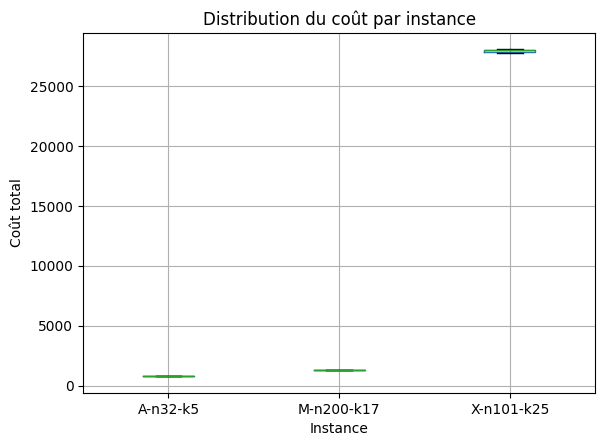

<Figure size 640x480 with 0 Axes>

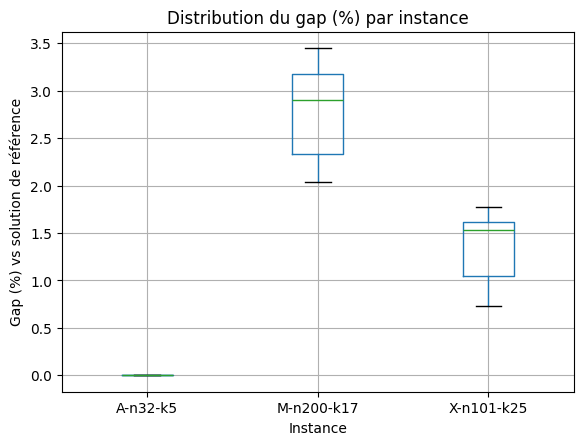

<Figure size 640x480 with 0 Axes>

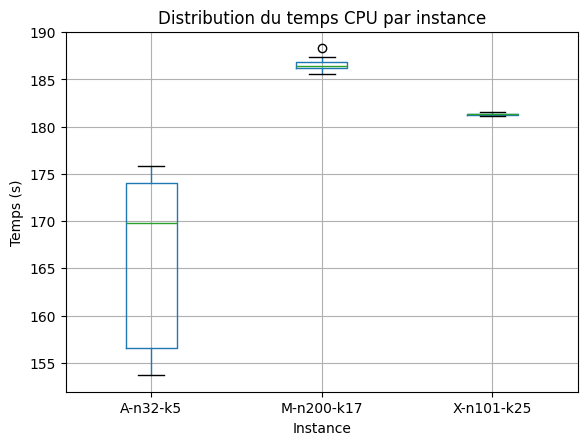

In [ ]:
import matplotlib.pyplot as plt

# 1) Boxplot du coût par instance
plt.figure()
df.boxplot(column="cost", by="instance")
plt.title("Distribution du coût par instance")
plt.suptitle("")  # enlève le titre automatique "cost by instance"
plt.xlabel("Instance")
plt.ylabel("Coût total")
plt.show()

# 2) Boxplot du gap (%) par instance
plt.figure()
df.boxplot(column="gap_pct", by="instance")
plt.title("Distribution du gap (%) par instance")
plt.suptitle("")
plt.xlabel("Instance")
plt.ylabel("Gap (%) vs solution de référence")
plt.show()

# 3) Boxplot du temps (s) par instance
plt.figure()
df.boxplot(column="time_s", by="instance")
plt.title("Distribution du temps CPU par instance")
plt.suptitle("")
plt.xlabel("Instance")
plt.ylabel("Temps (s)")
plt.show()


### Mini synthèse

## Synthèse du bench VRPLIB

Nous avons évalué le solveur HGS (implémenté dans `vrp_solver.py`) sur trois instances de
référence de la bibliothèque VRPLIB / Solomon :

- A-n32-k5 (CVRPLIB, petit CVRP)
- X-n101-k25 (CVRPLIB, instance de référence de taille moyenne)
- M-n200-k17 (Solomon, VRPTW avec fenêtres de temps)

Pour chaque instance, 20 exécutions indépendantes (seeds 0–19) ont été lancées avec une
limite de temps de 180 secondes. Les résultats montrent :

[→ ici ont colles les puces générées par la cellule `summary`]

Les boxplots du coût et du gap (%) confirment que l’algorithme est globalement stable
sur ces instances, avec une variabilité modérée entre les runs. Les temps de calcul
augmentent logiquement avec la taille et la difficulté du problème, M-n200-k17 étant
l’instance la plus coûteuse à résoudre en temps CPU.

Ces résultats serviront de point de comparaison pour :
- l’ajout de contraintes supplémentaires (fenêtres de temps, flotte hétérogène, etc.),
- l’analyse de l’impact des paramètres de la métaheuristique,
- la comparaison avec d’autres méthodes (recuit simulé, recherche avec tabous, ALNS).


# Démonstration

In [ ]:
![_- visual selection (1)-2.png](<attachment:_- visual selection (1)-2.png>)

# Imports + chargement de mon solveur

In [ ]:
# Cellule 1 — Imports de base + chargement du solveur

%load_ext autoreload
%autoreload 2

import os, sys, random, math, re, time
from pathlib import Path

import numpy as np

import vrp_solver as VS  # <-- mon fichier vrp_solver.py


# Menu interactif (.vrp / .txt) + lecture brute + Instance

In [ ]:
# Cellule 2 — Menu interactif (comme mon main) + lecture du fichier + construction de Instance

# On réutilise ta fonction interactive_choose_split() pour choisir les fichiers
paths = VS.interactive_choose_split()
if not paths:
    raise SystemExit("Aucun fichier sélectionné.")

inst_path = paths[0]  # on ne garde que le premier pour la démo
print(f"[1] Fichier sélectionné : {inst_path}")

# 1.a) Aperçu du contenu brut du fichier (pour 'Lire fichier (.vrp ou .txt)')
print("\n[1.a] Aperçu (40 premières lignes du fichier) :")
print("-" * 60)
with open(inst_path, "r", encoding="utf-8", errors="ignore") as f:
    for i, line in enumerate(f):
        if i >= 40:
            print("... (coupé)")
            break
        print(line.rstrip("\n"))

# 1.b) Construction de l'Instance (parse_solomon_txt ou parse_cvrplib_vrp)
print("\n[1.b] Construction de l'Instance à partir du fichier...")

if str(inst_path).lower().endswith(".txt"):
    inst = VS.parse_solomon_txt(str(inst_path))
else:
    inst = VS.parse_cvrplib_vrp(str(inst_path))

print("\nRésumé de l'Instance construite :")
print(f"  name       = {inst.name}")
print(f"  n          = {inst.n} clients")
print(f"  capacity   = {inst.capacity}")
print(f"  k (approx) = {inst.k} véhicules")
print(f"  has_tw     = {inst.has_tw} (fenêtres de temps)")
print(f"  coords     = shape {inst.coords.shape}")
print(f"  dist       = shape {inst.dist.shape}")



=== Sélection d'instances ===
[1] Avec TW (.txt, Solomon)   - 64 fichiers
[2] Sans TW (.vrp, CVRPLIB)   - 136 fichiers
[Q] Quitter

Fichiers détectés:
  [1] data\C101.txt
  [2] data\C1_2_1.txt
  [3] data\cvrplib\C101.txt
  [4] data\cvrplib\C1_2_1.txt
  [5] data\cvrplib\Vrp-Set-Solomon\C101.txt
  [6] data\cvrplib\Vrp-Set-Solomon\C102.txt
  [7] data\cvrplib\Vrp-Set-Solomon\C103.txt
  [8] data\cvrplib\Vrp-Set-Solomon\C104.txt
  [9] data\cvrplib\Vrp-Set-Solomon\C105.txt
  [10] data\cvrplib\Vrp-Set-Solomon\C106.txt
  [11] data\cvrplib\Vrp-Set-Solomon\C107.txt
  [12] data\cvrplib\Vrp-Set-Solomon\C108.txt
  [13] data\cvrplib\Vrp-Set-Solomon\C109.txt
  [14] data\cvrplib\Vrp-Set-Solomon\C1_10_2.txt
  [15] data\cvrplib\Vrp-Set-Solomon\C201.txt
  [16] data\cvrplib\Vrp-Set-Solomon\C202.txt
  [17] data\cvrplib\Vrp-Set-Solomon\C203.txt
  [18] data\cvrplib\Vrp-Set-Solomon\C204.txt
  [19] data\cvrplib\Vrp-Set-Solomon\C205.txt
  [20] data\cvrplib\Vrp-Set-Solomon\C206.txt
  [21] data\cvrplib\Vrp-Set-So

# Choisir paramètres automatiques (auto_params) + explications

In [7]:
# Cellule 3 — auto_params(inst) + explication de chaque paramètre

ap = VS.auto_params(inst)
fam, num, grp = VS._classify_instance(inst)

print("=== Étape 2 : Choix automatique des paramètres (auto_params) ===\n")

print(f"Famille détectée pour l'instance : fam = {fam}, num = {num}, grp = {grp}")
print("Idée générale : en fonction de la famille (Solomon / X / Ortec / CVRPLIB),")
print("du nombre de clients n et des fenêtres de temps, on adapte loops, pop, nnk,")
print("fast, workers et time_limit pour avoir un bon compromis qualité/temps.\n")

def expl(key, val):
    if key == "loops":
        return f"{val}  -> nombre de boucles GA (temps d'exploration global)."
    if key == "pop":
        return f"{val}  -> taille de la population HGS (nb de solutions en parallèle)."
    if key == "seed":
        return f"{val}  -> graine aléatoire stable dérivée du nom de l'instance."
    if key == "fast":
        return f"{val}  -> active ou non le mode 'fast' (utilisation des NN granulaire)."
    if key == "nnk":
        return f"{val}  -> nombre de voisins proches conservés par client."
    if key == "init":
        return f"{val}  -> heuristique de construction initiale ('regret' ou 'sweep')."
    if key == "workers":
        return f"{val}  -> nb de processus en parallèle (joblib, selon CPU/mémoire)."
    if key == "time_limit":
        return f"{val}  -> limite de temps pour la boucle HGS (en secondes, approx)."
    if key == "notes":
        return f"{val}  -> commentaire détaillé de recommend_workers_and_fast()."
    return f"{val}"

print("Paramètres choisis :\n")
for k in ["loops", "pop", "seed", "fast", "nnk", "init", "workers", "time_limit", "notes"]:
    v = ap.get(k)
    print(f"  {k:10s} = {expl(k, v)}")


=== Étape 2 : Choix automatique des paramètres (auto_params) ===

Famille détectée pour l'instance : fam = solomon, num = 101, grp = C
Idée générale : en fonction de la famille (Solomon / X / Ortec / CVRPLIB),
du nombre de clients n et des fenêtres de temps, on adapte loops, pop, nnk,
fast, workers et time_limit pour avoir un bon compromis qualité/temps.

Paramètres choisis :

  loops      = 600  -> nombre de boucles GA (temps d'exploration global).
  pop        = 56  -> taille de la population HGS (nb de solutions en parallèle).
  seed       = 3  -> graine aléatoire stable dérivée du nom de l'instance.
  fast       = False  -> active ou non le mode 'fast' (utilisation des NN granulaire).
  nnk        = 22  -> nombre de voisins proches conservés par client.
  init       = regret  -> heuristique de construction initiale ('regret' ou 'sweep').
  workers    = 6  -> nb de processus en parallèle (joblib, selon CPU/mémoire).
  time_limit = 30  -> limite de temps pour la boucle HGS (en second

# Construire les voisins proches (NN)

In [8]:
# Cellule 4 — Construction des voisins proches (NN) si fast=True

print("=== Étape 3 : Construction des voisins proches (NN) ===\n")

nn = None
if ap["fast"]:
    nn = VS.build_nn(inst.dist, ap["nnk"])
    print("On construit pour chaque client la liste de ses 'nnk' plus proches voisins.")
    print("Objectif : pendant RVND / ALNS, on ne teste que des moves avec ces voisins,")
    print("ce qui réduit le coût de calcul sans trop sacrifier la qualité.\n")

    max_show = min(inst.n, 5)
    for u in range(1, max_show + 1):
        print(f"Client {u:3d} -> voisins proches (indices) : {nn[u].tolist()}")
else:
    print("fast = False → pas de NN : on autorise tous les voisins (plus coûteux, plus complet).")


=== Étape 3 : Construction des voisins proches (NN) ===

fast = False → pas de NN : on autorise tous les voisins (plus coûteux, plus complet).


# Générer plusieurs solutions initiales (regret / sweep)

In [9]:
# Cellule 5 — Génération de plusieurs solutions initiales (regret ou sweep)

print("=== Étape 4 : Générer plusieurs solutions initiales ===\n")

init = "regret" if inst.has_tw else "sweep"
print(f"Heuristique utilisée pour les seeds : {init}\n")

initial_routes_list = []
initial_costs = []

for sid in range(1, 4):  # par exemple 3 seeds pour la démo
    random.seed(ap["seed"] + sid)
    np.random.seed(ap["seed"] + sid)

    if init == "regret":
        routes0 = VS.build_seed(inst)
        reason = "Heuristique par insertion avec 'regret' (bon pour TW / charges)."
    else:
        routes0 = VS.build_seed_sweep(inst)
        reason = "Heuristique 'sweep' : clients triés par angle autour du dépôt."

    c0 = VS.total_cost(inst, routes0)
    initial_routes_list.append(routes0)
    initial_costs.append(c0)

    print(f"--- Seed #{sid} ---")
    print(reason)
    for i, r in enumerate(routes0, 1):
        print(f"  Route init {sid}-{i}: {' '.join(map(str, r))}")
    print(f"  → Coût initial seed #{sid} = {c0:.2f}\n")


=== Étape 4 : Générer plusieurs solutions initiales ===

Heuristique utilisée pour les seeds : regret

--- Seed #1 ---
Heuristique par insertion avec 'regret' (bon pour TW / charges).
  Route init 1-1: 0 20 24 25 27 29 30 28 26 23 22 21 47 0
  Route init 1-2: 0 67 65 63 62 74 72 61 64 68 66 69 0
  Route init 1-3: 0 5 3 7 8 10 11 9 6 4 2 1 75 0
  Route init 1-4: 0 43 42 41 40 44 46 45 48 51 50 52 49 0
  Route init 1-5: 0 90 87 86 83 82 84 85 88 89 91 0
  Route init 1-6: 0 13 17 18 19 15 16 14 12 99 0
  Route init 1-7: 0 98 96 95 94 92 93 97 100 0
  Route init 1-8: 0 32 33 31 35 37 38 39 36 34 0
  Route init 1-9: 0 57 55 54 53 56 58 60 59 0
  Route init 1-10: 0 81 78 76 71 70 73 77 79 80 0
  → Coût initial seed #1 = 878.36

--- Seed #2 ---
Heuristique par insertion avec 'regret' (bon pour TW / charges).
  Route init 2-1: 0 20 24 25 27 29 30 28 26 23 22 21 47 0
  Route init 2-2: 0 67 65 63 62 74 72 61 64 68 66 69 0
  Route init 2-3: 0 5 3 7 8 10 11 9 6 4 2 1 75 0
  Route init 2-4: 0 43 42

# Améliorer ces solutions via RVND

In [10]:
# Cellule 6 — Amélioration des solutions initiales via RVND

print("=== Étape 5 : Améliorer les seeds via RVND ===\n")
print("RVND = Randomized Variable Neighborhood Descent :")
print("- on applique plusieurs voisinages (Or-opt, 2-opt, relocate, swap, 2-opt* inter-routes)")
print("- on les enchaîne tant qu'on améliore, en changeant d'ordre de façon aléatoire.\n")

improved_routes_list = []
improved_costs = []

for idx, routes0 in enumerate(initial_routes_list, start=1):
    c0 = initial_costs[idx-1]

    routes_imp = VS.rvnd(inst, [r.copy() for r in routes0], max_loops=3, nn=nn)
    c1 = VS.total_cost(inst, routes_imp)

    improved_routes_list.append(routes_imp)
    improved_costs.append(c1)

    print(f"Seed #{idx} :")
    print(f"  Coût avant RVND : {c0:.2f}")
    print(f"  Coût après  RVND : {c1:.2f}")
    if c1 < c0:
        print("  → RVND a amélioré la solution (meilleures routes).")
    else:
        print("  → RVND n'a pas trouvé d'amélioration significative.")
    for i, r in enumerate(routes_imp, 1):
        print(f"  Route RVND {idx}-{i}: {' '.join(map(str, r))}")
    print()


=== Étape 5 : Améliorer les seeds via RVND ===

RVND = Randomized Variable Neighborhood Descent :
- on applique plusieurs voisinages (Or-opt, 2-opt, relocate, swap, 2-opt* inter-routes)
- on les enchaîne tant qu'on améliore, en changeant d'ordre de façon aléatoire.

Seed #1 :
  Coût avant RVND : 878.36
  Coût après  RVND : 854.31
  → RVND a amélioré la solution (meilleures routes).
  Route RVND 1-1: 0 20 24 25 27 29 30 28 26 23 22 21 0
  Route RVND 1-2: 0 67 65 63 62 74 72 61 64 68 66 69 0
  Route RVND 1-3: 0 5 3 7 8 10 11 9 6 4 2 1 0
  Route RVND 1-4: 0 43 42 41 40 44 46 45 48 51 50 52 49 47 0
  Route RVND 1-5: 0 90 87 86 83 82 84 85 88 89 91 0
  Route RVND 1-6: 0 13 17 18 19 15 16 14 12 99 0
  Route RVND 1-7: 0 98 96 95 94 92 93 97 100 75 0
  Route RVND 1-8: 0 32 33 31 35 37 38 39 36 34 0
  Route RVND 1-9: 0 57 55 54 53 56 58 60 59 0
  Route RVND 1-10: 0 81 78 76 71 70 73 77 79 80 0

Seed #2 :
  Coût avant RVND : 878.36
  Coût après  RVND : 854.31
  → RVND a amélioré la solution (mei

# Créer la population HGS initiale

In [11]:
# Cellule 7 — Création de la population HGS

print("=== Étape 6 : Création de la population HGS initiale ===\n")

def fit(rs):
    return VS.total_cost(inst, rs)

pop_routes = []
pop_tours = []

# 1) On commence par les solutions améliorées des seeds
for routes_imp in improved_routes_list:
    pop_routes.append(routes_imp)
    pop_tours.append(VS.tour_from_routes(routes_imp))

# 2) On complète avec quelques solutions aléatoires (tour random + split + RVND)
target_pop = min(ap["pop"], 10)  # on limite pour la démo
nodes = list(range(1, inst.n + 1))

while len(pop_routes) < target_pop:
    random.shuffle(nodes)
    tour = nodes.copy()
    if inst.has_tw:
        routes = VS.split_vrptw(inst, tour) or [[0, u, 0] for u in tour]
    else:
        routes = VS.split_cvrp(inst, tour) or [[0, u, 0] for u in tour]
    routes = VS.rvnd(inst, routes, max_loops=2, nn=nn)
    pop_routes.append(routes)
    pop_tours.append(VS.tour_from_routes(routes))

print(f"Population initiale construite : {len(pop_routes)} individus.\n")

for idx, routes in enumerate(pop_routes, 1):
    print(f"  Individu {idx:02d} : coût = {fit(routes):.2f}, nb routes = {len(routes)}")

best_idx = min(range(len(pop_routes)), key=lambda i: fit(pop_routes[i]))
best_routes = pop_routes[best_idx]
best_cost = fit(best_routes)

print(f"\nMeilleur individu initial : #{best_idx+1}, coût = {best_cost:.2f}")


=== Étape 6 : Création de la population HGS initiale ===

Population initiale construite : 10 individus.

  Individu 01 : coût = 854.31, nb routes = 10
  Individu 02 : coût = 854.31, nb routes = 10
  Individu 03 : coût = 854.31, nb routes = 10
  Individu 04 : coût = 5770.96, nb routes = 100
  Individu 05 : coût = 5770.96, nb routes = 100
  Individu 06 : coût = 5770.96, nb routes = 100
  Individu 07 : coût = 5770.96, nb routes = 100
  Individu 08 : coût = 5770.96, nb routes = 100
  Individu 09 : coût = 5770.96, nb routes = 100
  Individu 10 : coût = 5770.96, nb routes = 100

Meilleur individu initial : #1, coût = 854.31


# Boucle GA détaillée (OX, split, ALNS, RVND, garder le meilleur)

In [ ]:
# Cellule 8 — Boucle GA / HGS détaillée : OX, split, ALNS, RVND, mise à jour du meilleur

print("=== Étape 7 : Boucle GA (HGS) avec détails ===\n")

def alns_perturb_and_repair(routes_in, label=""):
    """Petite étape ALNS : remove+repair avec shaw ou random, puis regret_repair."""
    q = max(2, inst.n // 20)
    if np.random.rand() < 0.7:
        removed = VS.shaw_removal(inst, routes_in, q)
        reason = "shaw_removal (clients corrélés/proches en distance)"
    else:
        removed = VS.random_removal(inst, routes_in, q)
        reason = "random_removal (suppression aléatoire)"

    print(f"    [ALNS-{label}] On enlève {len(removed)} clients ({reason}).")
    cand = VS.remove_customers(routes_in, removed)
    cand = VS.regret_repair(inst, cand, removed)
    c_cand = fit(cand)
    print(f"    [ALNS-{label}] Après repair : {len(cand)} routes, coût = {c_cand:.2f}")
    return cand

max_gen = 5  # nombre de générations pour la démonstration

for g in range(1, max_gen + 1):
    print(f"\n===== Génération {g} =====")

    # Sélection de deux parents au hasard
    i, j = np.random.choice(len(pop_tours), 2, replace=False)
    p1, p2 = pop_tours[i], pop_tours[j]
    print(f"  Parents choisis : #{i+1} (c={fit(pop_routes[i]):.2f}), "
          f"#{j+1} (c={fit(pop_routes[j]):.2f})")

    # 1) Crossover OX
    child_tour = VS.ox_crossover(p1, p2)
    print(f"  [OX] Tour enfant longueur {len(child_tour)} ; aperçu : {child_tour[:20]}{' ...' if len(child_tour) > 20 else ''}")

    # 2) split (découpage optimal du tour en routes)
    if inst.has_tw:
        child_routes = VS.split_vrptw(inst, child_tour)
    else:
        child_routes = VS.split_cvrp(inst, child_tour)

    if child_routes is None:
        print("  [split] Échec du découpage → on lance une étape ALNS à partir du meilleur courant.")
        cand = alns_perturb_and_repair(best_routes, label="split-fail")
        child_tour = VS.tour_from_routes(cand)
        if inst.has_tw:
            child_routes = VS.split_vrptw(inst, child_tour) or cand
        else:
            child_routes = VS.split_cvrp(inst, child_tour) or cand

    print(f"  [split] {len(child_routes)} routes obtenues, coût = {fit(child_routes):.2f}")

    # 3) RVND sur l'enfant
    c_before_rvnd = fit(child_routes)
    child_routes = VS.rvnd(inst, child_routes, max_loops=3, nn=nn)
    c_after_rvnd = fit(child_routes)
    print(f"  [RVND] Coût avant = {c_before_rvnd:.2f}, après = {c_after_rvnd:.2f}")

    # 4) ALNS additionnelle (optionnelle, comme dans mon HGS)
    if np.random.rand() < 0.30:
        print("  [ALNS-post] Perturbation/réparation complémentaire sur l'enfant.")
        cand = alns_perturb_and_repair(child_routes, label="post")
        c_cand = fit(cand)
        if c_cand < c_after_rvnd:
            print(f"  [ALNS-post] Amélioration acceptée : {c_after_rvnd:.2f} → {c_cand:.2f}")
            child_routes = cand
            c_after_rvnd = c_cand
        else:
            print(f"  [ALNS-post] Amélioration rejetée (coût {c_cand:.2f} >= {c_after_rvnd:.2f}).")

    # 5) Insertion dans la population
    pop_routes.append(child_routes)
    pop_tours.append(VS.tour_from_routes(child_routes))
    print(f"  [pop] Enfant inséré (coût = {c_after_rvnd:.2f}), population = {len(pop_routes)} individus.")

    # Suppression du pire si trop d'individus
    if len(pop_routes) > ap["pop"]:
        worst_idx = int(np.argmax([fit(r) for r in pop_routes]))
        print(f"  [pop] Suppression du pire individu #{worst_idx+1}, coût = {fit(pop_routes[worst_idx]):.2f}")
        pop_routes.pop(worst_idx)
        pop_tours.pop(worst_idx)

    # 6) Garder le meilleur
    if c_after_rvnd < best_cost - 1e-9:
        best_routes = child_routes
        best_cost = c_after_rvnd
        print(f"  [best] *** Nouveau meilleur trouvé : coût = {best_cost:.2f} ***")
    else:
        print(f"  [best] Meilleur inchangé : coût = {best_cost:.2f}")



=== Étape 7 : Boucle GA (HGS) avec détails ===


===== Génération 1 =====
  Parents choisis : #9 (c=5770.96), #2 (c=854.31)
  [OX] Tour enfant longueur 100 ; aperçu : [80, 65, 55, 81, 12, 98, 46, 68, 79, 89, 26, 22, 92, 5, 44, 51, 24, 20, 56, 62] ...
  [split] Échec du découpage → on lance une étape ALNS à partir du meilleur courant.
    [ALNS-split-fail] On enlève 5 clients (shaw_removal (clients corrélés/proches en distance)).
    [ALNS-split-fail] Après repair : 10 routes, coût = 854.31
  [split] 10 routes obtenues, coût = 854.31
  [RVND] Coût avant = 854.31, après = 854.31
  [pop] Enfant inséré (coût = 854.31), population = 11 individus.
  [best] Meilleur inchangé : coût = 854.31

===== Génération 2 =====
  Parents choisis : #1 (c=854.31), #10 (c=5770.96)
  [OX] Tour enfant longueur 100 ; aperçu : [58, 26, 45, 94, 59, 86, 55, 40, 31, 83, 60, 54, 96, 30, 98, 74, 72, 61, 64, 68] ...
  [split] Échec du découpage → on lance une étape ALNS à partir du meilleur courant.
    [ALNS-split-f

# Calculer le coût total (formule + résultat)

In [13]:
# Cellule 9 — Calcul du coût total de la meilleure solution

print("=== Étape 8 : Calcul du coût total ===\n")

print("Formule (VRP classique) :")
print("  cost(total) = somme_sur_routes  somme_sur_arcs  dist[i, j]")
print("C'est-à-dire : pour chaque route (0 -> ... -> 0), on additionne")
print("les distances entre chaque client consécutif (y compris dépôt ↔ clients).\n")

best_cost = VS.total_cost(inst, best_routes)

print(f"Nombre de routes dans la meilleure solution : {len(best_routes)}\n")
for i, r in enumerate(best_routes, 1):
    print(f"  Route best #{i}: {r}")
print(f"\n→ Coût total de la meilleure solution : {best_cost:.2f}")


=== Étape 8 : Calcul du coût total ===

Formule (VRP classique) :
  cost(total) = somme_sur_routes  somme_sur_arcs  dist[i, j]
C'est-à-dire : pour chaque route (0 -> ... -> 0), on additionne
les distances entre chaque client consécutif (y compris dépôt ↔ clients).

Nombre de routes dans la meilleure solution : 10

  Route best #1: [0, 20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21, 0]
  Route best #2: [0, 67, 65, 63, 62, 74, 72, 61, 64, 68, 66, 69, 0]
  Route best #3: [0, 5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 0]
  Route best #4: [0, 43, 42, 41, 40, 44, 46, 45, 48, 51, 50, 52, 49, 47, 0]
  Route best #5: [0, 90, 87, 86, 83, 82, 84, 85, 88, 89, 91, 0]
  Route best #6: [0, 13, 17, 18, 19, 15, 16, 14, 12, 99, 0]
  Route best #7: [0, 98, 96, 95, 94, 92, 93, 97, 100, 75, 0]
  Route best #8: [0, 32, 33, 31, 35, 37, 38, 39, 36, 34, 0]
  Route best #9: [0, 57, 55, 54, 53, 56, 58, 60, 59, 0]
  Route best #10: [0, 81, 78, 76, 71, 70, 73, 77, 79, 80, 0]

→ Coût total de la meilleure solution : 854.31


# Comparer au BKS (.sol) et calculer le gap

In [14]:
# Cellule 10 — Référence BKS (.sol) et calcul du gap

print("=== Étape 9 : Comparaison au BKS (gap) ===\n")

print("Formule du gap en % :")
print("  gap(%) = 100 * (cost_best - ref_cost) / ref_cost\n")

ref_cost = VS.find_sol_reference_cost(inst, inst_path)

if ref_cost is None or ref_cost <= 0:
    print("Aucune référence .sol trouvée pour cette instance → gap N/A.")
else:
    gap = 100.0 * (best_cost - ref_cost) / ref_cost
    print(f"Ref (BKS)   = {ref_cost:.2f}")
    print(f"Cost (best) = {best_cost:.2f}")
    print(f"gap         = {gap:.2f} %")


=== Étape 9 : Comparaison au BKS (gap) ===

Formule du gap en % :
  gap(%) = 100 * (cost_best - ref_cost) / ref_cost

Ref (BKS)   = 827.30
Cost (best) = 854.31
gap         = 3.27 %


# Afficher routes + coût + gap

=== Étape 10 : Résumé final de la solution ===

Instance : C101.txt

Routes finales :
  Route #1: 0 20 24 25 27 29 30 28 26 23 22 21 0
  Route #2: 0 67 65 63 62 74 72 61 64 68 66 69 0
  Route #3: 0 5 3 7 8 10 11 9 6 4 2 1 0
  Route #4: 0 43 42 41 40 44 46 45 48 51 50 52 49 47 0
  Route #5: 0 90 87 86 83 82 84 85 88 89 91 0
  Route #6: 0 13 17 18 19 15 16 14 12 99 0
  Route #7: 0 98 96 95 94 92 93 97 100 75 0
  Route #8: 0 32 33 31 35 37 38 39 36 34 0
  Route #9: 0 57 55 54 53 56 58 60 59 0
  Route #10: 0 81 78 76 71 70 73 77 79 80 0

Coût total = 854.31
Référence (BKS) = 827.30
gap             = 3.27 %


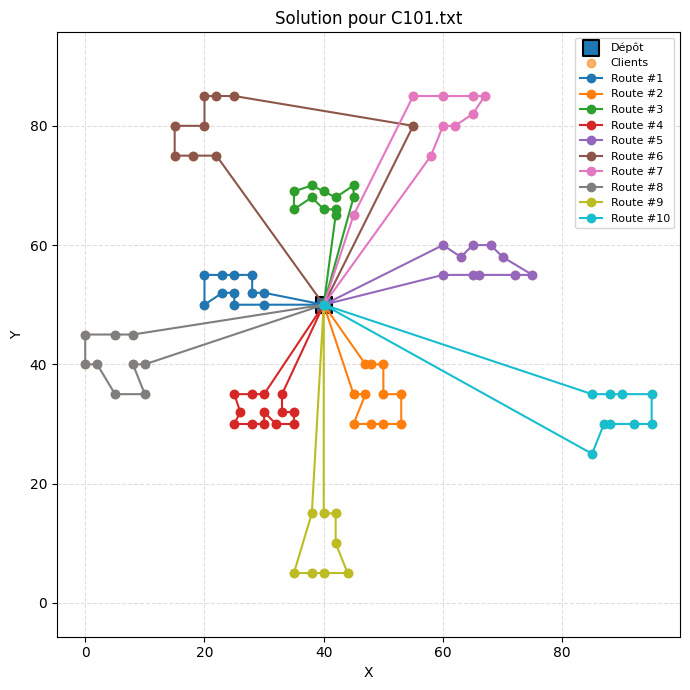

In [16]:
# Cellule 11 — Résumé final : routes + coût + gap + graphe des routes

import matplotlib.pyplot as plt

print("=== Étape 10 : Résumé final de la solution ===\n")

print(f"Instance : {inst.name}\n")
print("Routes finales :")
for i, r in enumerate(best_routes, 1):
    print(f"  Route #{i}: {' '.join(map(str, r))}")

print(f"\nCoût total = {best_cost:.2f}")
if ref_cost is not None and ref_cost > 0:
    gap = 100.0 * (best_cost - ref_cost) / ref_cost
    print(f"Référence (BKS) = {ref_cost:.2f}")
    print(f"gap             = {gap:.2f} %")
else:
    print("Référence (BKS) inconnue → gap N/A")

# ============================
#   GRAPHE DES ROUTES
# ============================

plt.figure(figsize=(7, 7))

# 1) Dépôt
plt.scatter(
    inst.coords[0, 0],
    inst.coords[0, 1],
    marker="s",
    s=120,
    edgecolor="black",
    linewidth=1.5,
    label="Dépôt"
)

# 2) Clients
plt.scatter(
    inst.coords[1:, 0],
    inst.coords[1:, 1],
    alpha=0.6,
    label="Clients"
)

# 3) Chaque route en couleur différente
# Matplotlib choisira les couleurs automatiquement
for idx, r in enumerate(best_routes, 1):
    xs = [inst.coords[i, 0] for i in r]
    ys = [inst.coords[i, 1] for i in r]
    plt.plot(xs, ys, marker="o", linewidth=1.5, label=f"Route #{idx}")

plt.title(f"Solution pour {inst.name}")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()
